In [213]:
from matplotlib import pyplot as plt
import matplotlib.patches
import matplotlib as mpl
from matplotlib import cm
import numpy as np
import glob
import pandas as pd
import seaborn as sns

import pvlib
from scipy.interpolate import interp1d
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
import random
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.svm import SVC
from sklearn import metrics

from pymer4.models import Lmer
from joblib import Parallel, delayed
import scipy.stats as st

In [14]:
# Climate Data
temp = pd.read_csv('data/Climate with PCA12.csv', delimiter = ',')

# Albedo

In [4]:
# Import data and do not brightness normalize

data_no_bn = pd.read_csv('data/MASTER_garden_threeleavesperplant.csv')
data_no_bn = data_no_bn[(data_no_bn['LMA']<200) | (data_no_bn['LMA'].isnull())]
data_no_bn[['population', 'g','n', 'leafno']] = data_no_bn['Code'].str.split('_', expand=True)
data_no_bn['pop_code'] = data_no_bn['population'].str[-3:]
data_no_bn['pop_no'] = data_no_bn['population'].str[:2]
data_no_bn = data_no_bn[~data_no_bn.Garden.isnull()]
data_no_bn = pd.concat([data_no_bn[["Garden", "pop_code",'g','n','pop_no',"LMA"]],data_no_bn.iloc[:,54:2105]], axis = 1)
data_means_no_bn = data_no_bn.groupby(['Garden', "pop_code", 'pop_no',"g","n"]).mean().reset_index()


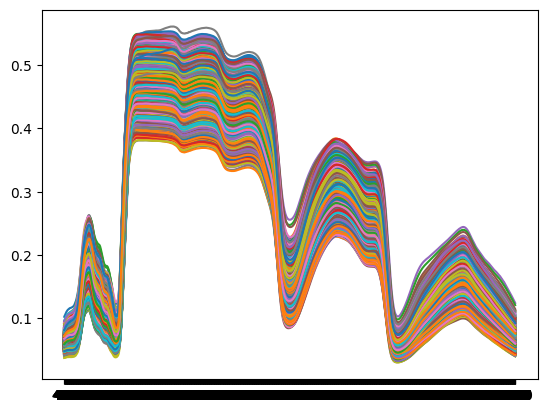

In [5]:
# Plot data
plt.plot(data_no_bn.iloc[:,50:2101].T);

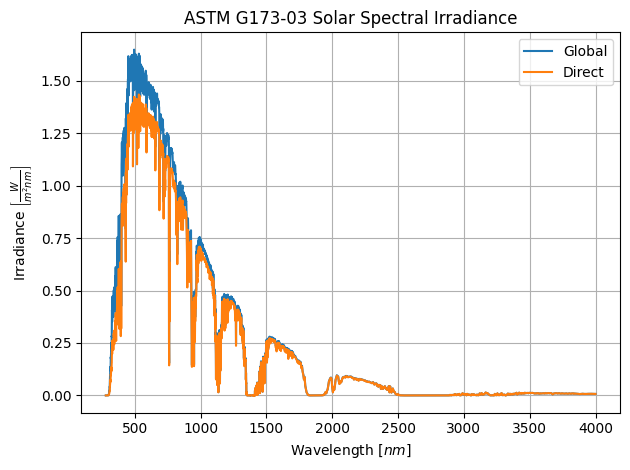

In [8]:
# Get Reference Spectra

am15 = pvlib.spectrum.get_reference_spectra(standard="ASTM G173-03")

# Plot
# plt.plot(am15.index, am15["extraterrestrial"], label="Extraterrestrial")
plt.plot(am15.index, am15["global"], label="Global")
plt.plot(am15.index, am15["direct"], label="Direct")
# plt.plot(irr['Wvlgth nm'], irr["Direct"], label="Direct")

plt.xlabel(r"Wavelength $[nm]$")
plt.ylabel(r"Irradiance $\left[\frac{W}{m^2 nm}\right]$")
plt.title("ASTM G173-03 Solar Spectral Irradiance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Interpolate irradiance where nm gap is >1

interp_func = interp1d(am15.index, am15["global"], kind='linear', bounds_error=False, fill_value=0)
irradiance_interp = interp_func(np.arange(400,2451))

In [21]:
# Calculate albedo
num = data_means_no_bn.iloc[:, 6:]*irradiance_interp
den = irradiance_interp

vis = num.iloc[:, :300]
nswir = num.iloc[:, 300:]

albedo = data_means_no_bn[["Garden", "pop_code",'g','n','pop_no',"LMA"]]
albedo ['vis'] = vis.sum(axis = 1)/(den[:300].sum())
albedo ['nswir'] = nswir.sum(axis = 1)/(den[300:].sum())

/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/1111778717.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albedo ['vis'] = vis.sum(axis = 1)/(den[:300].sum())
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/1111778717.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albedo ['nswir'] = nswir.sum(axis = 1)/(den[300:].sum())


In [22]:
# Set Garden Order
def func(row):
    if row['Garden'] == 'Yuma':
        return 3
    elif row['Garden'] =='Agua Fria':
        return 2 
    else:
        return 1

albedo['gard_order'] = albedo.apply(func, axis=1)


albedo = albedo.merge(temp[['code', 'MAT']], left_on = 'pop_code', right_on = 'code').drop('code', axis = 1)
albedo = albedo.sort_values(by = ['gard_order', 'MAT'], ascending = True, na_position = 'first')



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/506325969.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albedo['gard_order'] = albedo.apply(func, axis=1)


/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/449717151.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_colorsb = get_cols(cm.get_cmap('Blues', 15))
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/449717151.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_colorsg = get_cols(cm.get_cmap('Greys', 15))
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/449717151.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()

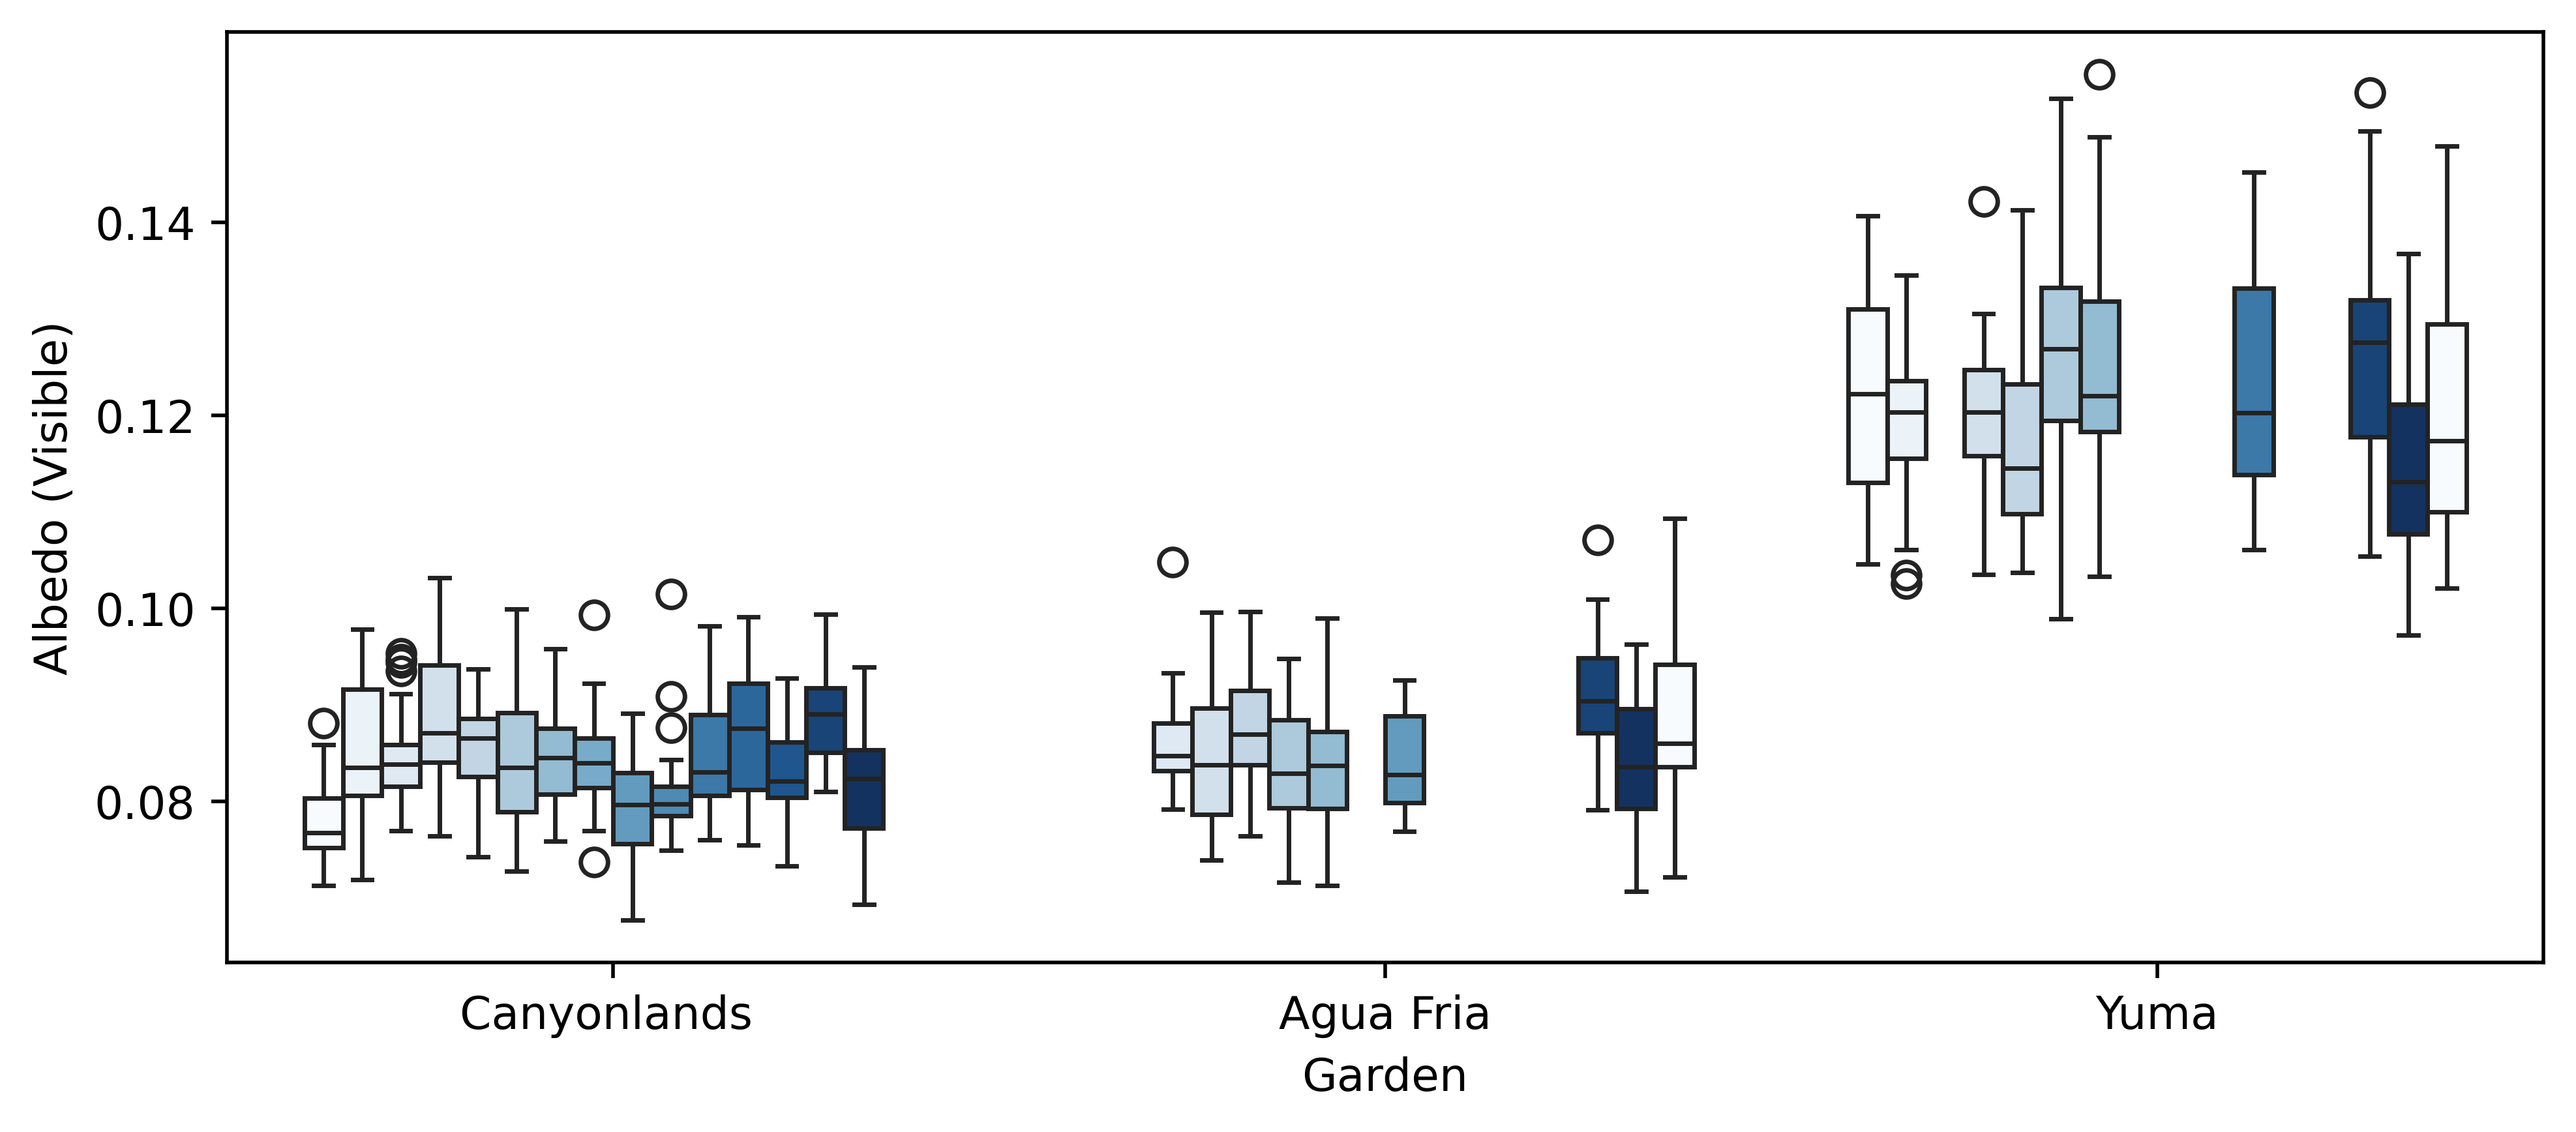

In [23]:
mpl.rcParams['mathtext.default'] = 'regular'
# fig, ax = plt.subplots(3,1,figsize=(8,8), dpi = 500)
fig=plt.figure(figsize=(8,10), dpi = 500)
ax0 = plt.subplot(311)
# ax1 = plt.subplot(312)
# ax2 = plt.subplot(313, sharex = ax1)


def get_cols(cmap):
    my_colors = []
    
    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        my_colors = np.append(my_colors, matplotlib.colors.rgb2hex(rgba))
    return(my_colors)

my_colorsb = get_cols(cm.get_cmap('Blues', 15))
my_colorsg = get_cols(cm.get_cmap('Greys', 15))
my_colorsr = get_cols(cm.get_cmap('Reds', 15))

# fig, ax = plt.subplots(1,1)

# my_colors = {x: 'pink' if x == 'Agua Fria' else 'grey' for x in lma_means.Garden.unique()}

sns.boxplot(data = albedo, 
            y = 'vis',
            x = 'Garden',  
            hue = 'pop_code', 
            palette = my_colorsb, 
            order = ['Canyonlands ', 'Agua Fria', 'Yuma'], 
            ax = ax0)

# sns.boxplot(data = albedo, 
#             y = 'vis',
#             x = 'Garden',  
#             hue = 'pop_code', 
#             palette = my_colorsg, 
#             order = ['Canyonlands ', 'Agua Fria', 'Yuma'], 
#             ax = ax1)


# sns.boxplot(data = albedo, 
#             y = 'vis',
#             x = 'Garden',  
#             hue = 'pop_code', 
#             palette = my_colorsr, 
#             order = ['Canyonlands ', 'Agua Fria', 'Yuma'], 
#             ax = ax2)

def func(row):
    if row['Garden'] == 'Yuma':
        return 'red'
    elif row['Garden'] =='Agua Fria':
        return 'gray' 
    else:
        return 'blue'

ax0.legend([], [], frameon=False)
# ax1.legend([], [], frameon=False)
# ax2.legend([], [], frameon=False)
ax0.set_ylabel('Albedo (Visible)')


fig.tight_layout()


/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/636384964.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_colorsb = get_cols(cm.get_cmap('Blues', 15))
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/636384964.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_colorsg = get_cols(cm.get_cmap('Greys', 15))
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/636384964.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()

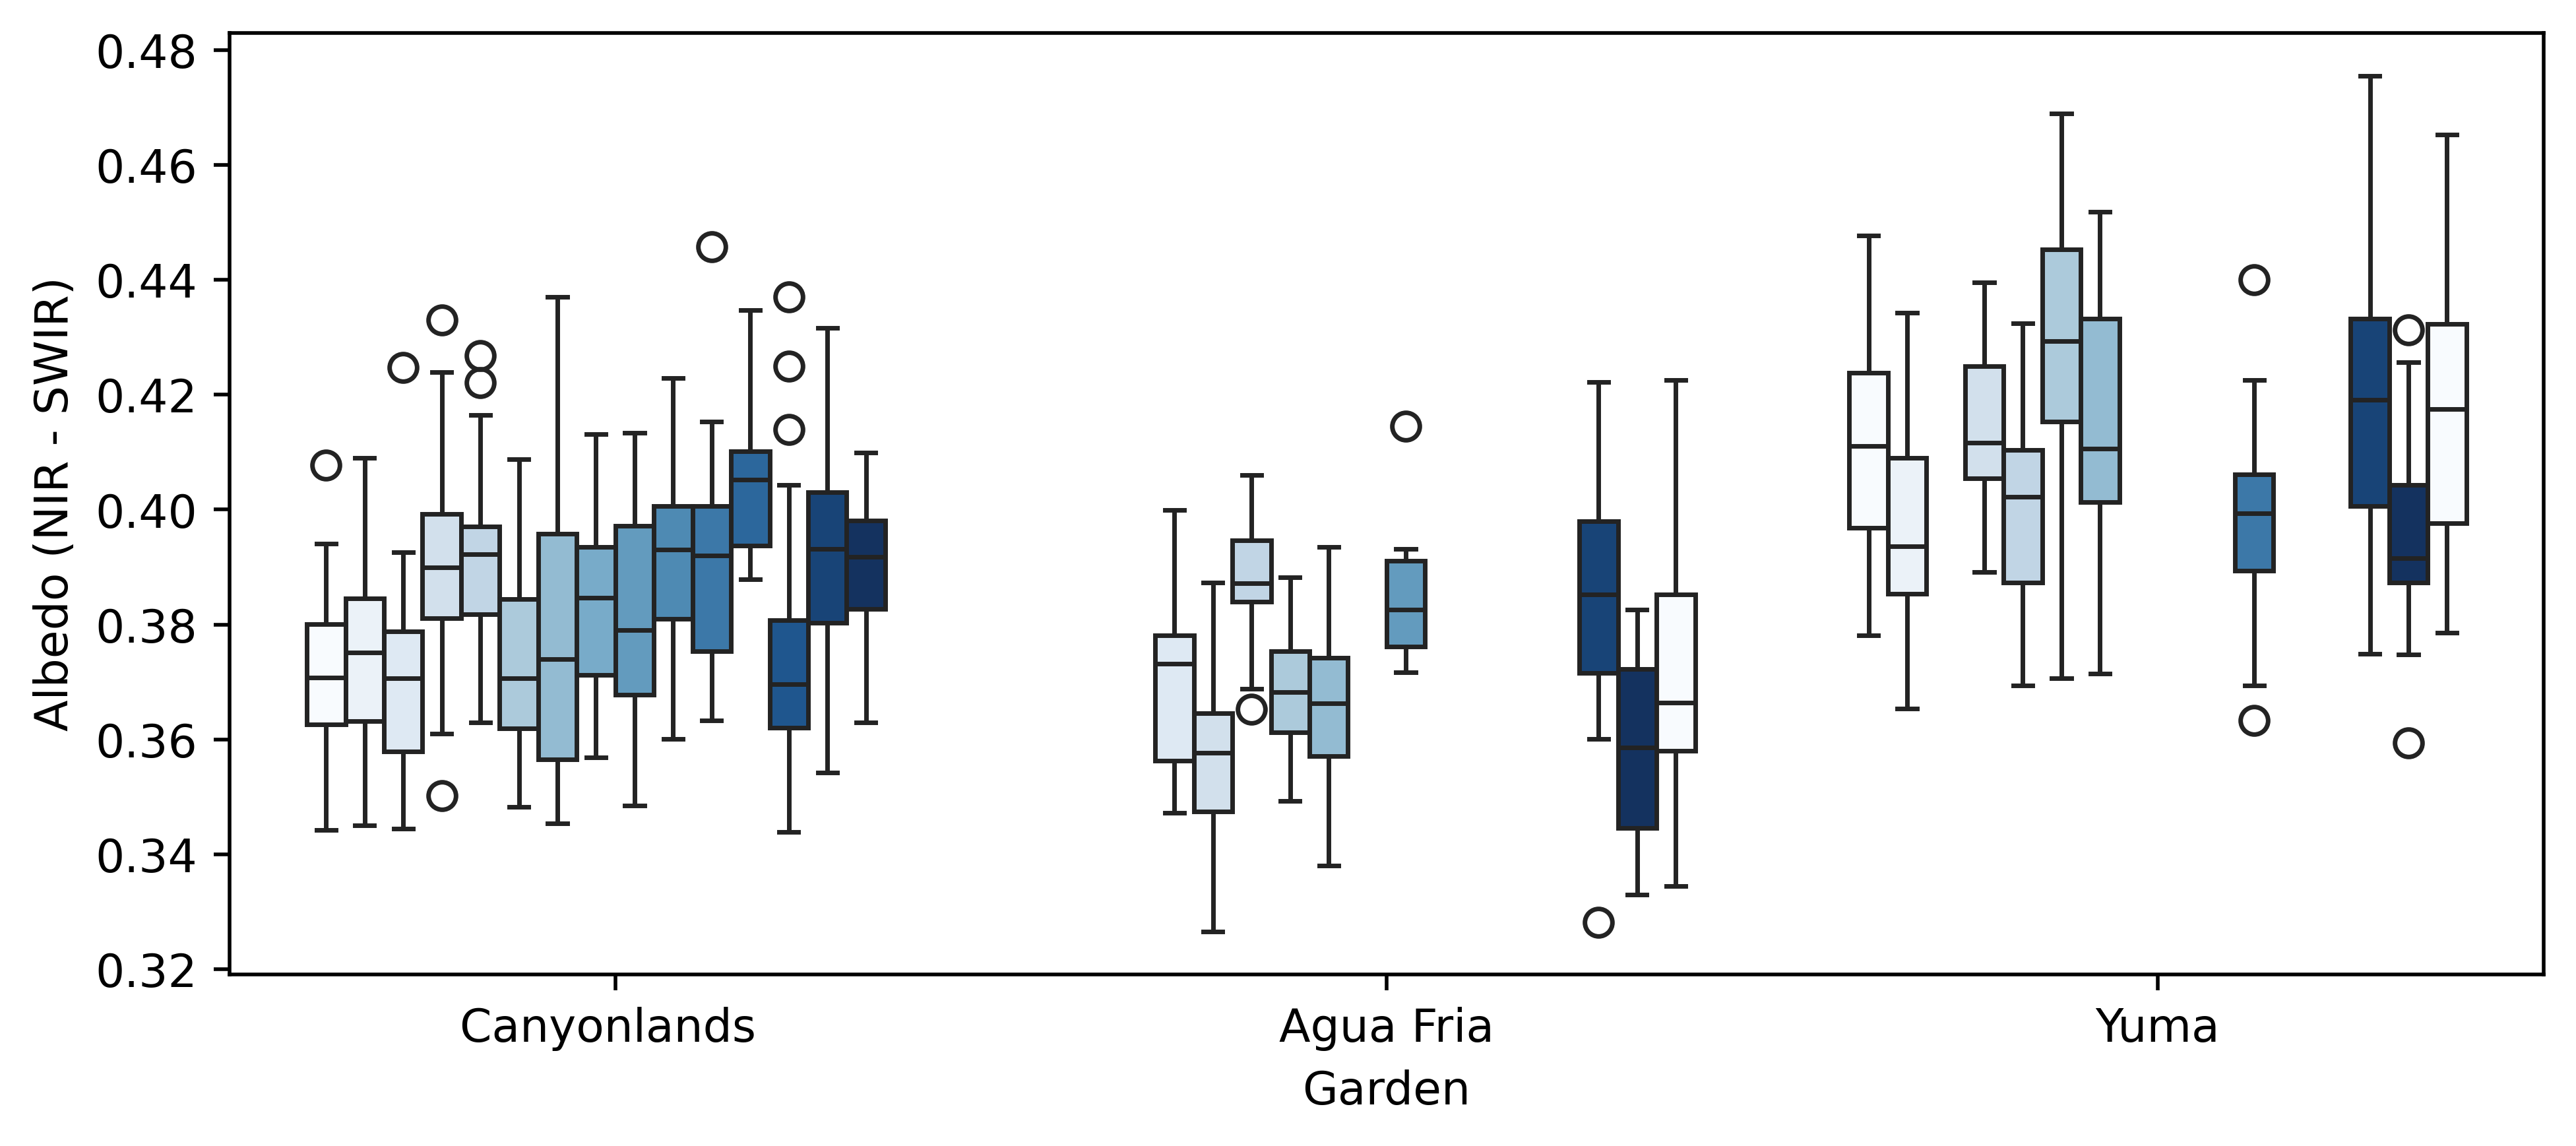

In [24]:

fig=plt.figure(figsize=(8,10), dpi = 500)
ax0 = plt.subplot(311)
# ax1 = plt.subplot(312)
# ax2 = plt.subplot(313, sharex = ax1)


def get_cols(cmap):
    my_colors = []
    
    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        my_colors = np.append(my_colors, matplotlib.colors.rgb2hex(rgba))
    return(my_colors)

my_colorsb = get_cols(cm.get_cmap('Blues', 15))
my_colorsg = get_cols(cm.get_cmap('Greys', 15))
my_colorsr = get_cols(cm.get_cmap('Reds', 15))

# fig, ax = plt.subplots(1,1)

# my_colors = {x: 'pink' if x == 'Agua Fria' else 'grey' for x in lma_means.Garden.unique()}

sns.boxplot(data = albedo, 
            y = 'nswir',
            x = 'Garden',  
            hue = 'pop_code', 
            palette = my_colorsb, 
            order = ['Canyonlands ', 'Agua Fria', 'Yuma'], 
            ax = ax0)

# sns.boxplot(data = albedo, 
#             y = 'nswir',
#             x = 'Garden',  
#             hue = 'pop_code', 
#             palette = my_colorsg, 
#             order = ['Canyonlands ', 'Agua Fria', 'Yuma'], 
#             ax = ax1)


# sns.boxplot(data = albedo, 
#             y = 'nswir',
#             x = 'Garden',  
#             hue = 'pop_code', 
#             palette = my_colorsr, 
#             order = ['Canyonlands ', 'Agua Fria', 'Yuma'], 
#             ax = ax2)

def func(row):
    if row['Garden'] == 'Yuma':
        return 'red'
    elif row['Garden'] =='Agua Fria':
        return 'gray' 
    else:
        return 'blue'

ax0.legend([], [], frameon=False)
# ax1.legend([], [], frameon=False)

# ax2.legend([], [], frameon=False)
ax0.set_ylabel('Albedo (NIR - SWIR)')


fig.tight_layout()


In [26]:
# Tukey Pairwise HSD for NSWIR
albedo['Garden'] = albedo['Garden'].astype('category')

tukey = pairwise_tukeyhsd(endog=albedo['nswir'],
                          groups=albedo['Garden'],
                          alpha=0.05)

print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1       group2    meandiff p-adj lower  upper  reject
-------------------------------------------------------------
   Agua Fria Canyonlands    0.0111   0.0 0.0074 0.0147   True
   Agua Fria         Yuma   0.0399   0.0 0.0362 0.0437   True
Canyonlands          Yuma   0.0289   0.0 0.0253 0.0324   True
-------------------------------------------------------------


In [27]:
# Tukey pairwise for VIS
tukey = pairwise_tukeyhsd(endog=albedo['vis'],
                          groups=albedo['Garden'],
                          alpha=0.05)

print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
   Agua Fria Canyonlands   -0.0017 0.0271 -0.0033 -0.0002   True
   Agua Fria         Yuma   0.0358    0.0  0.0342  0.0374   True
Canyonlands          Yuma   0.0375    0.0   0.036   0.039   True
----------------------------------------------------------------


# All Other Analyses

In [28]:
# Brightness Normalization
def brightness_norm(indat, conv_perc = True):
    outdat = indat / np.linalg.norm(indat, axis=0)

    if conv_perc == True:
        outdat = outdat*100
        
    return outdat

In [91]:
# Import Data and apply Brightness normalizaiton
data = pd.read_csv('data/MASTER_garden_threeleavesperplant.csv')
data = data.drop(["Garden","Code", 'LMA', 'Spectra quality control'], axis = 1)
data = data.iloc[:,50:2101]
data = data.apply(brightness_norm, axis =1)


# Import data again to get column headers
data2 = pd.read_csv('data/MASTER_garden_threeleavesperplant.csv')
data2 = data2[(data2['LMA']<200) | (data2['LMA'].isnull())]
data2[['population', 'g','n', 'leafno']] = data2['Code'].str.split('_', expand=True)
data2['pop_code'] = data2['population'].str[-3:]
data2['pop_no'] = data2['population'].str[:2]
data = pd.concat([data2[["Garden", "pop_code",'g','n','pop_no',"LMA"]],data], axis = 1)

# Clean Data
data = data[~data.Garden.isnull()]
data = data[data['850']>3.3]

# Get mean values for each tree and population
data_means = data.groupby(['Garden', "pop_code", 'pop_no',"g","n"]).mean().reset_index()
pop_means = data_means.drop(['pop_no','g','n',"LMA"], axis =1).groupby(["Garden", "pop_code"]).mean().reset_index()

ut_group = ['CLF', 'JLA', 'KKH']
sw = ['TSE','PSA', 'TSZ']
kwf = ['KWF']

data_means["ecotype"] = np.where(data_means["pop_code"].isin(ut_group), "Colorado", np.where(data_means["pop_code"].isin(kwf), 'kwf', np.where(data_means['pop_code'].isin(sw), 'sw','sonoran')))
all_data = data_means.drop(['pop_no','g','n','LMA'], axis = 1)


In [114]:
def sub_data(data_in, no, col): 
    
    data_out = None
    for i,d in enumerate(np.unique(data_in[col])):
        random.seed(99)
        tmp = data_in[data_in[col]==d]
        if len(tmp)< no:
            continue
        else:
            rand_seq = np.random.choice(np.arange(0, len(tmp)), no, replace = False)
            
            tmp = tmp.iloc[rand_seq,:]
            if not isinstance(data_out, type(None)):
                data_out = pd.concat([data_out, tmp])   
            else:
                data_out = tmp
    return(data_out)


def sub_data2(data_in, no_values, col1, col2, random_nu): 
    data_out = None
    
    for i,j in enumerate(np.unique(data_in[col1])):
        random.seed(100+random_nu)
        
        tmp = data_in[data_in[col1]==j]
        
        for l, z in enumerate(np.unique(data_in[col2])):
            tmp2 = tmp[tmp[col2]==z]
            
            if len(tmp2)< no_values:
                continue
                
            else:
                rand_seq = np.random.choice(np.arange(0, len(tmp2)), no_values, replace = False)
                tmp2 = tmp2.iloc[rand_seq,:]
                
                if not isinstance(data_out, type(None)):
                    data_out = pd.concat([data_out, tmp2])   
                else:
                    data_out = tmp2
    return(data_out)



In [154]:
# Get a subset of data for first pca analysis
sub_pops = ['CLF', 'KWF', 'BCE', 'PSA', 'SCT']
subset_data = all_data[all_data.pop_code.isin(sub_pops)]
subset_data_pops = sub_data(subset_data, 104, 'pop_code')
subset_data_garden = sub_data(all_data[all_data.pop_code!='CCR'], 104, "Garden")

subset_data_eco = sub_data2(all_data, 40, 'ecotype','Garden',7)



# LMA

In [30]:
def func(row):
    if row['Garden'] == 'Yuma':
        return 3
    elif row['Garden'] =='Agua Fria':
        return 2 
    else:
        return 1
lma_means = data_means.iloc[:, [0,1,5]]

lma_means['gard_order'] = lma_means.apply(func, axis=1)

lma_means = lma_means.merge(temp[['code', 'MAT']], left_on = 'pop_code', right_on = 'code').drop('code', axis = 1)
lma_means = lma_means.sort_values(by = ['gard_order', 'MAT'], ascending = True, na_position = 'first')


/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/1498131820.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lma_means['gard_order'] = lma_means.apply(func, axis=1)


In [34]:
# LMA Stats by garden
lma_means[['Garden', 'LMA']].groupby('Garden').agg({"LMA": [np.mean, np.max, np.min]})

/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3011526985.py:1: FutureWarning: The provided callable <function mean at 0x110add940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  lma_means[['Garden', 'LMA']].groupby('Garden').agg({"LMA": [np.mean, np.max, np.min]})
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3011526985.py:1: FutureWarning: The provided callable <function max at 0x110add040> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  lma_means[['Garden', 'LMA']].groupby('Garden').agg({"LMA": [np.mean, np.max, np.min]})
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3011526985.py:1: FutureWarning: The provided callable <function min at 0x110add160> is currently using SeriesGroupBy

LMA                       
                    mean         max        min
Garden                                         
Agua Fria      88.149876  146.666667  52.333333
Canyonlands    72.918348  104.500000  46.666667
Yuma          108.389776  148.666667  72.666667

In [39]:
# Compare differences in LMA across Gardens
lma_means = lma_means[~np.isnan(lma_means.LMA)]
tukey = pairwise_tukeyhsd(endog=lma_means['LMA'],
                          groups=lma_means['Garden'],
                          alpha=0.05)

print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj  lower    upper   reject
-----------------------------------------------------------------
   Agua Fria Canyonlands  -15.2315   0.0 -17.8408 -12.6222   True
   Agua Fria         Yuma  20.2399   0.0  17.5695  22.9103   True
Canyonlands          Yuma  35.4714   0.0  32.9702  37.9727   True
-----------------------------------------------------------------


# PRI

In [32]:
w531 = data_means.iloc[:,137]
w570 = data_means.iloc[:,176]
sub = w531-w570
ad = w531+w570
pri = data_means[['Garden','pop_code']]
pri['pri']=sub/ad

/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/1910008977.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pri['pri']=sub/ad


In [144]:
pri[['Garden', 'pri']].groupby('Garden').agg({"pri": [np.mean, np.max, np.min]})

/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/104159979.py:1: FutureWarning: The provided callable <function mean at 0x110add940> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pri[['Garden', 'pri']].groupby('Garden').agg({"pri": [np.mean, np.max, np.min]})
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/104159979.py:1: FutureWarning: The provided callable <function max at 0x110add040> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  pri[['Garden', 'pri']].groupby('Garden').agg({"pri": [np.mean, np.max, np.min]})
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/104159979.py:1: FutureWarning: The provided callable <function min at 0x110add160> is currently using SeriesGroupBy.min. In a futu

pri                    
                  mean       max       min
Garden                                    
Agua Fria     0.017589  0.035738 -0.019777
Canyonlands   0.018713  0.035408 -0.024769
Yuma         -0.011196  0.019615 -0.081890

In [41]:
# Compare PRI across gardens
tukey = pairwise_tukeyhsd(endog=pri['pri'],
                          groups=pri['Garden'],
                          alpha=0.05)

print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
   Agua Fria Canyonlands    0.0011 0.4033 -0.0009  0.0032  False
   Agua Fria         Yuma  -0.0288    0.0 -0.0309 -0.0267   True
Canyonlands          Yuma  -0.0299    0.0 -0.0319 -0.0279   True
----------------------------------------------------------------


# PCA

In [116]:
# PCA with all data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data_pops.iloc[:,2:-1])
# Note that results are unaffected by scaling

pca = PCA(n_components=4)
pca.fit(scaled_data)
PC = pca.fit_transform(scaled_data)

principalDf = pd.DataFrame(data = PC
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

finalDf_main = pd.concat([principalDf,subset_data_pops[['Garden', 'pop_code']].reset_index()], axis = 1)

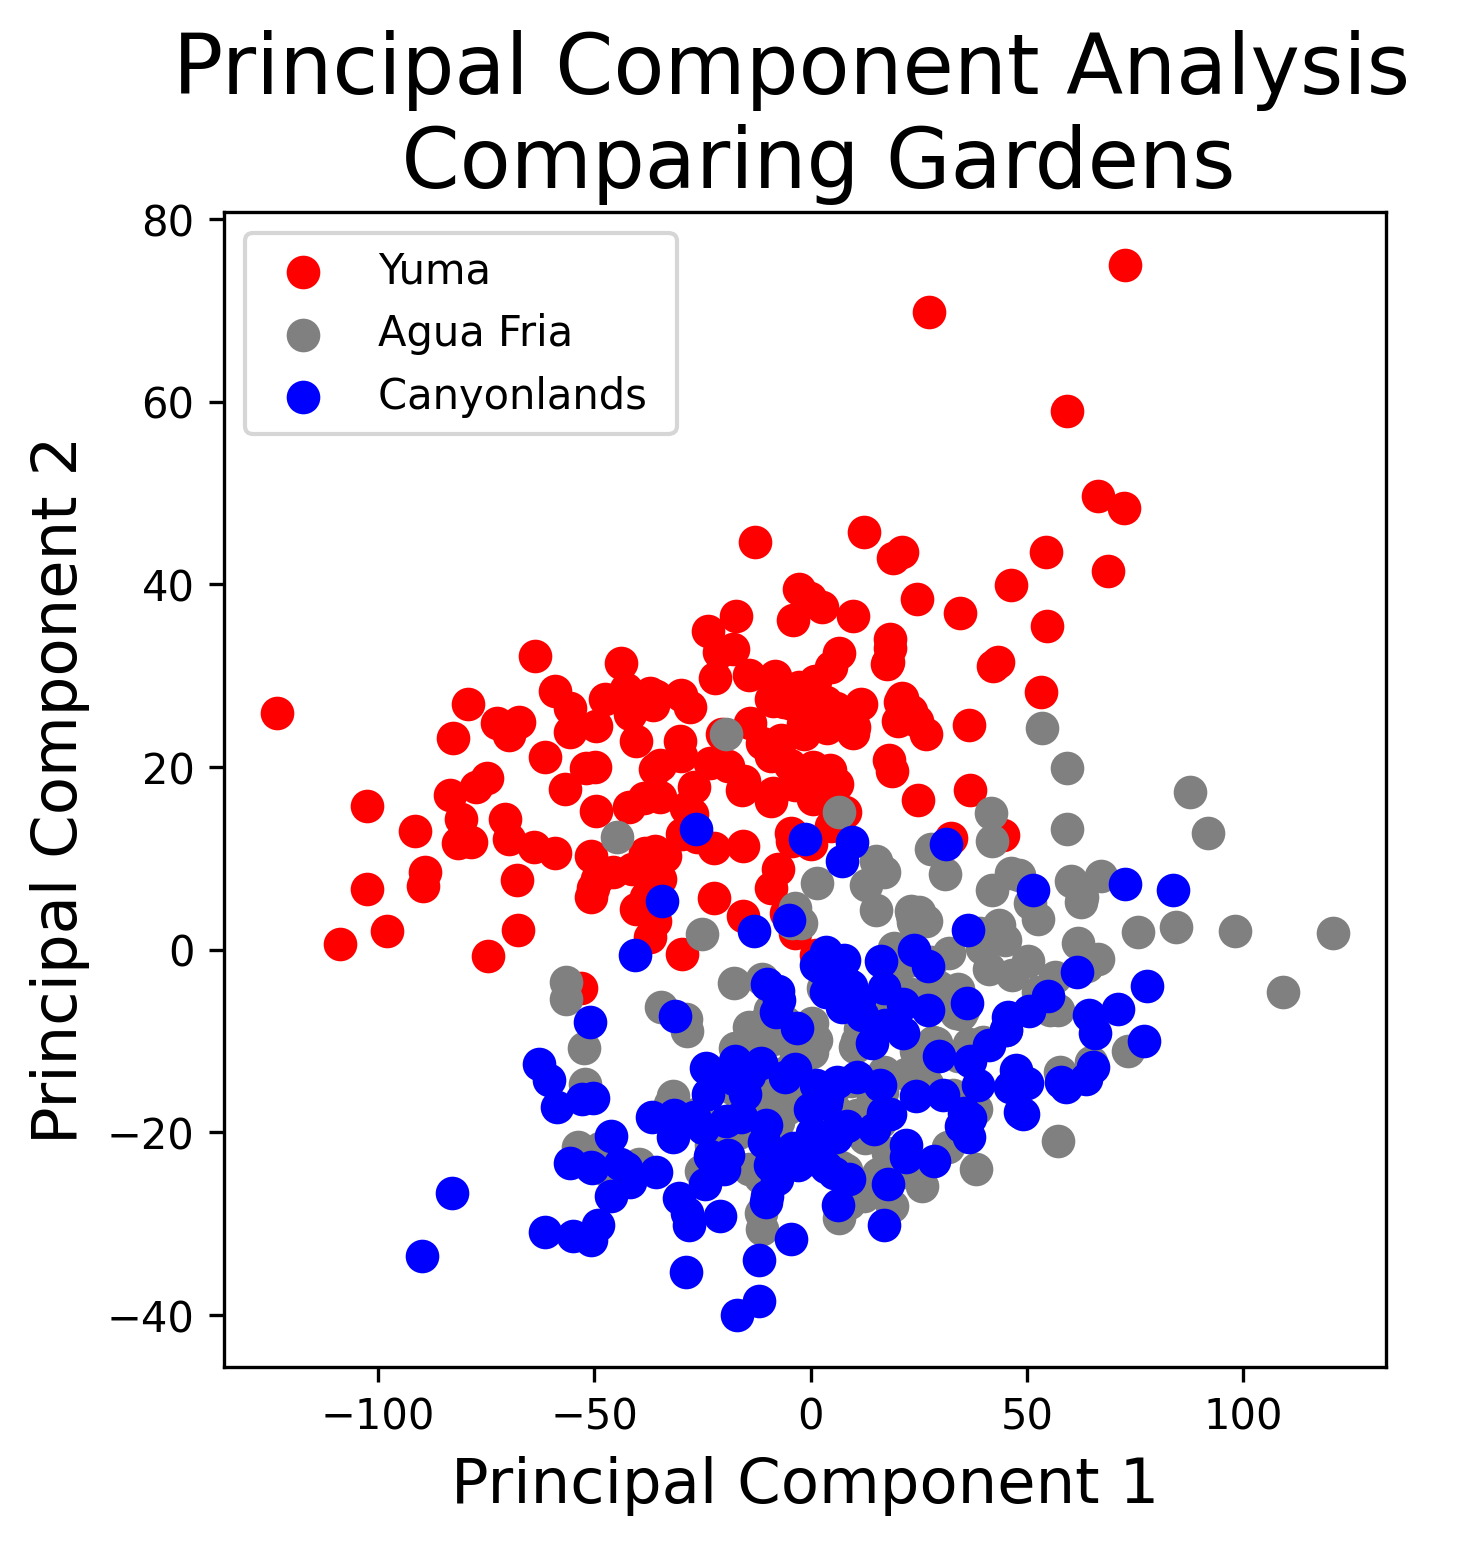

In [117]:
fig = plt.figure(figsize = (5,5), dpi = 300)
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Principal Component Analysis \n Comparing Gardens', fontsize = 20)

targets = ['Yuma', "Agua Fria", 'Canyonlands ']
colors = ['r', 'grey', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_main['Garden'] == target
    ax.scatter(finalDf_main.loc[indicesToKeep, 'principal component 1']
               , finalDf_main.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid(False)

In [ ]:
# PCA distance matrix with Agua Fria and Canyonlands data

In [140]:
subset_data_noy = subset_data_eco[(subset_data_eco["Garden"]!='Yuma') & (subset_data_eco['ecotype']!='kwf')]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data_noy.iloc[:,2:-1])
# Note that results are unaffected by scaling

pca = PCA(n_components=20)
pca.fit(scaled_data)
PC = pca.fit_transform(scaled_data)

principalDf = pd.DataFrame(data = PC)
finalDf = pd.concat([principalDf, subset_data_noy[['Garden', 'ecotype']].reset_index()], axis = 1).drop('index', axis=1)


In [141]:
out_center_means = pd.DataFrame(index = np.arange(0,20))

for n in np.unique(finalDf['ecotype']): 
    for g in np.unique(finalDf["Garden"]):
        tmp = finalDf[(finalDf['ecotype']==n)& (finalDf['Garden']==g)].drop(["Garden",'ecotype'], axis = 1)
        name = n+"_"+g
        pc_mean = np.empty(20)
        for i in range(20):
            pc_mean[i]=tmp.iloc[:,i].mean()
        
        out_center_means[name]=pc_mean
pops = out_center_means.columns

D = np.empty([len(pops),len(pops)])
for i in range(len(pops)):
    
    nrow = np.empty(len(pops))
    
    for j in range(len(pops)):
        dist = np.linalg.norm(out_center_means.iloc[:,i] - out_center_means.iloc[:,j])
#         print(pops[i],"-", pops[j], " : ", round(dist, 3)*1000)
        nrow[j]=dist
    D[i,:]=nrow

/Users/megan/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:629: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


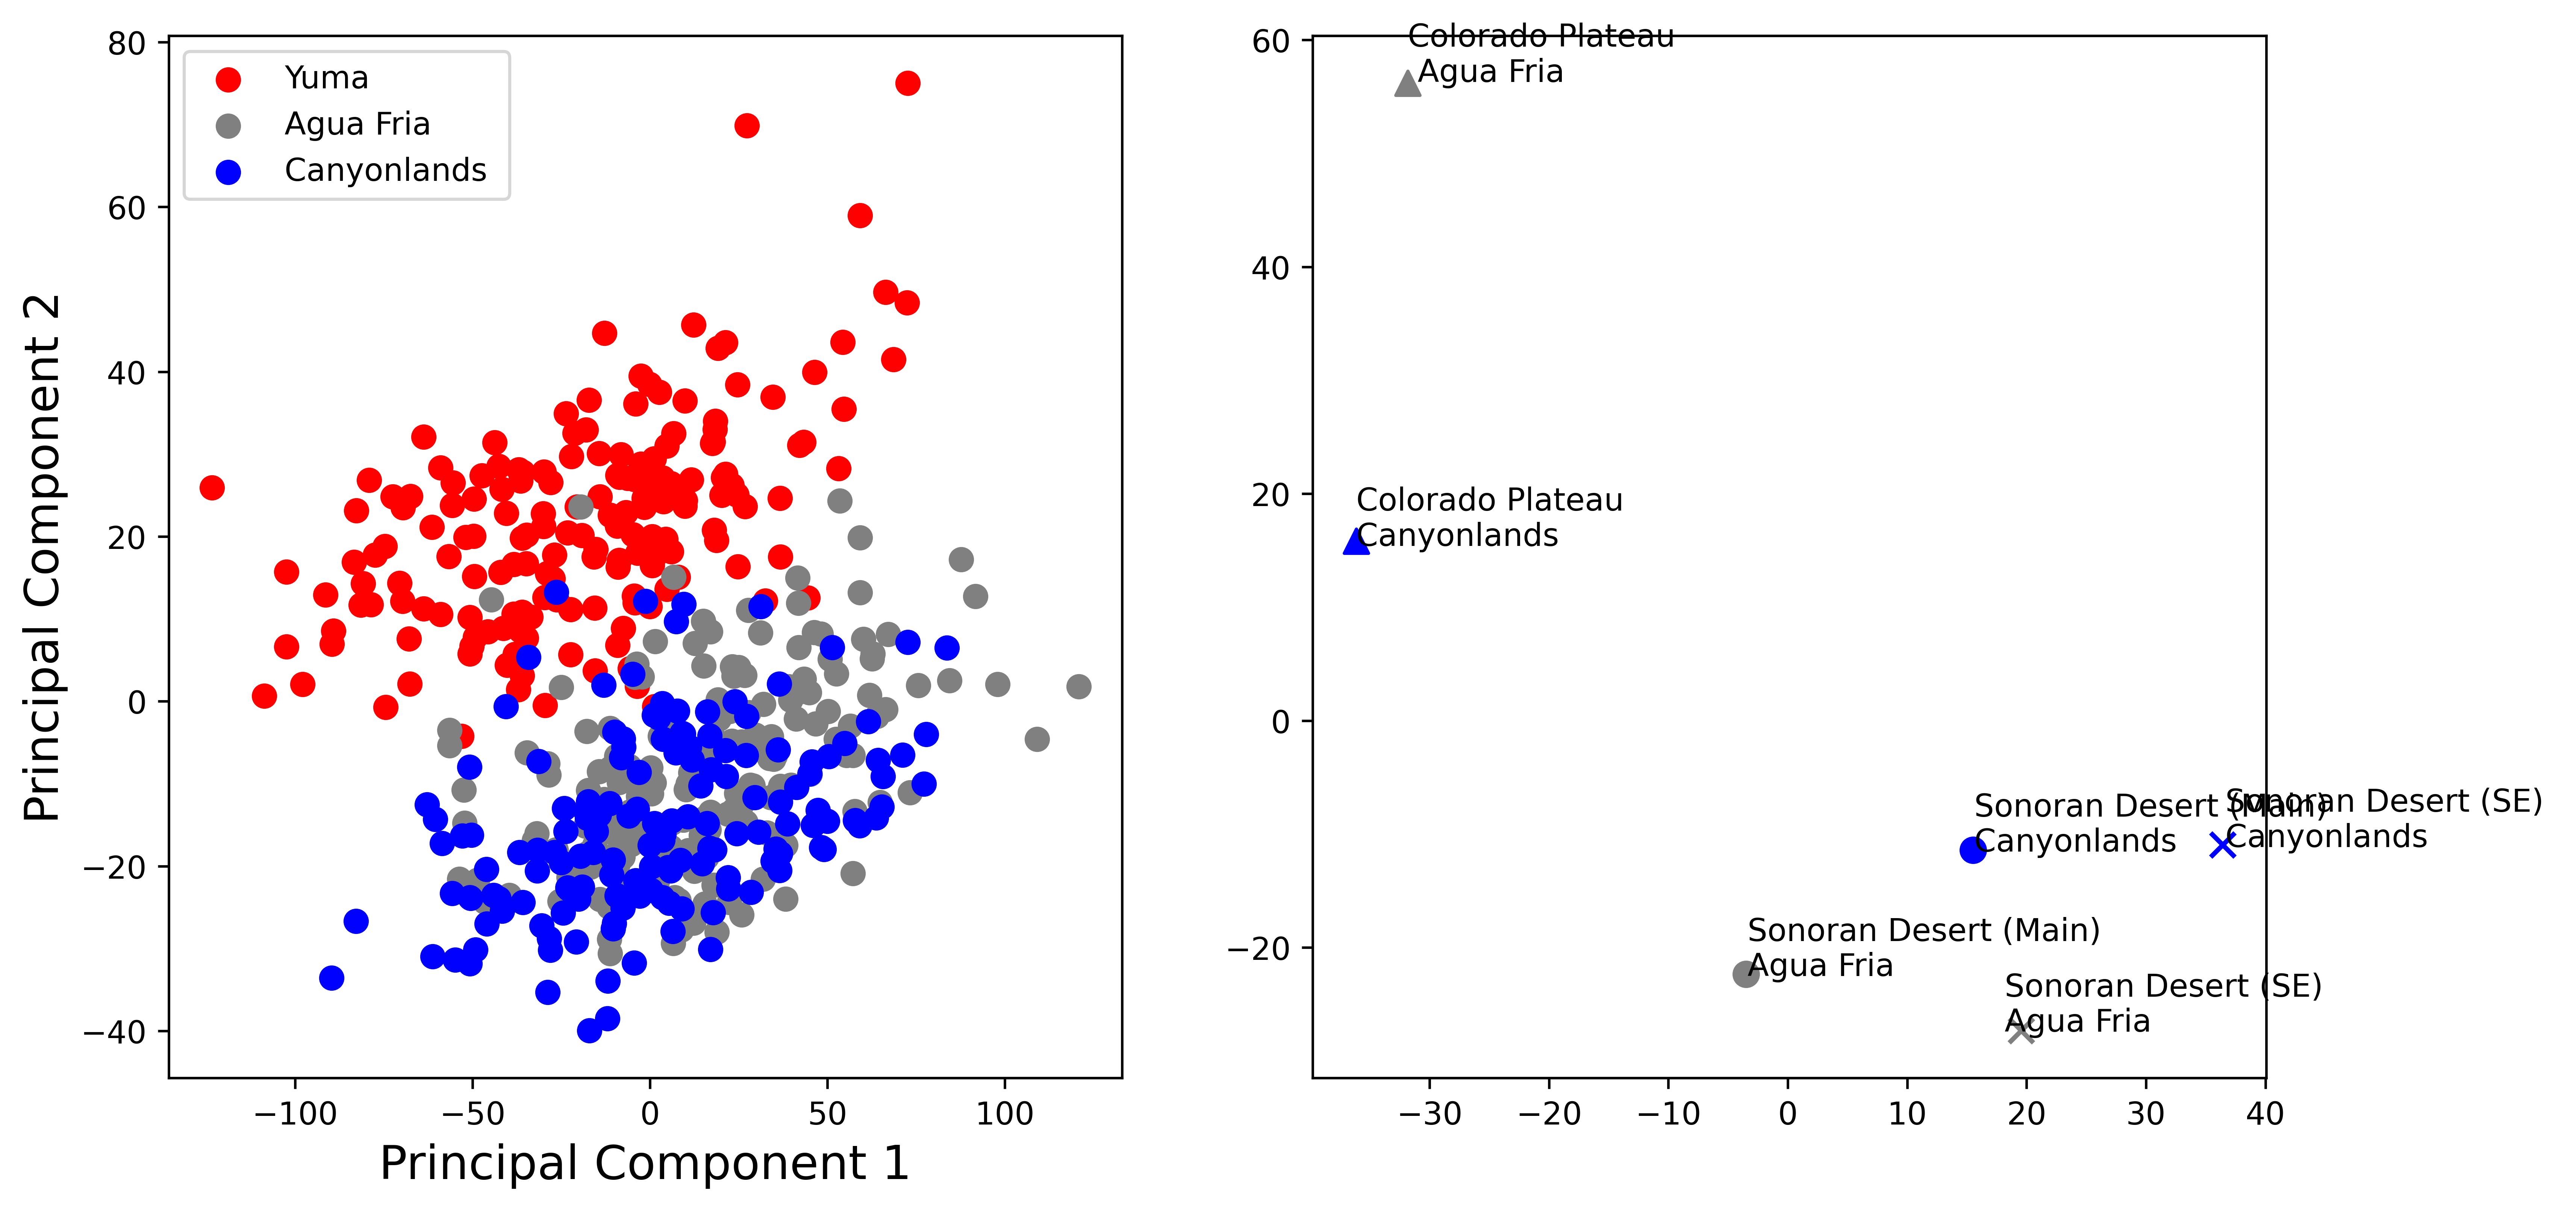

In [143]:
fig, ax = plt.subplots(1,2, figsize = (12,6), dpi = 600)


ax[0].set_xlabel('Principal Component 1', fontsize = 15)
ax[0].set_ylabel('Principal Component 2', fontsize = 15)
# ax[0].set_title('Principal Component Analysis', fontsize = 20)

targets = ['Yuma', "Agua Fria", 'Canyonlands ']
colors = ['r', 'grey', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_main['Garden'] == target
    ax[0].scatter(finalDf_main.loc[indicesToKeep, 'principal component 1']
               , finalDf_main.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax[0].legend(targets)
ax[0].grid(False)

colors = np.resize(['grey','blue'],6)
mark = np.resize(np.repeat(['^','o', 'x'],2), 6)

pops2 = ['Colorado Plateau \n Agua Fria', 
         'Colorado Plateau \nCanyonlands ', 
         'Sonoran Desert (Main) \nAgua Fria',
       'Sonoran Desert (Main) \nCanyonlands ', 
         'Sonoran Desert (SE) \nAgua Fria', 
         'Sonoran Desert (SE) \nCanyonlands '
         ]

mds = MDS(2, random_state = 0)
x=mds.fit_transform(D)

locs =[[0,.15],[0,-.4],[.12,-.15],[.1,-.1],[-1.4,-0.05],[.2,-0.15]]

# Plot the labels
for i,label in enumerate(pops2):
    l = locs[i]
    ax[1].scatter(x[i,0],x[i,1],
                marker = mark[i],
                color = colors[i],
               s = 60)
    ax[1].text(x[i,0]+l[0],x[i,1]+l[1],label)
# axs[0].set_title('Regional Genotype SVM \n(84.7% Accuracy)')

# ax[1].text(-2.2,1.8,'b)');
# ax[1].text(-8.9,1.8,'a)');

# SVM

In [158]:
# Create SVM Function
import warnings 

def svm_(data_in, col):

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data_in.iloc[:,2:-1], data_in[col], test_size=0.3, random_state=42, stratify=data_in[col]) 
    
    # Scale Data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X_train)
    
    
    tuned_parameters = [
        {"kernel": ["rbf"], "gamma": [10000., 1000., 100., 10., 1., 1e-1, 1e-2, 1e-3, 1e-4], "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]},
    ]

    clf = GridSearchCV(SVC(probability=True), tuned_parameters, scoring="accuracy")
    clf.fit(scaled_data, y_train)

    scaler = StandardScaler()
    y_true, y_pred = y_test, clf.predict(scaler.fit_transform(X_test))

    print("Accuracy:",metrics.accuracy_score(y_true, y_pred))
    acc = metrics.accuracy_score(y_test, y_pred)
        
    return y_true, y_pred, acc

In [159]:
# SVM for predicting population
pop_true, pop_pred, pop_acc = svm_(subset_data_pops, 'pop_code')

Accuracy: 0.717948717948718


In [175]:
# SVM for predicting Garden
gard_true, gard_pred, gard_acc = svm_(subset_data_garden, 'Garden')

Accuracy: 0.925531914893617


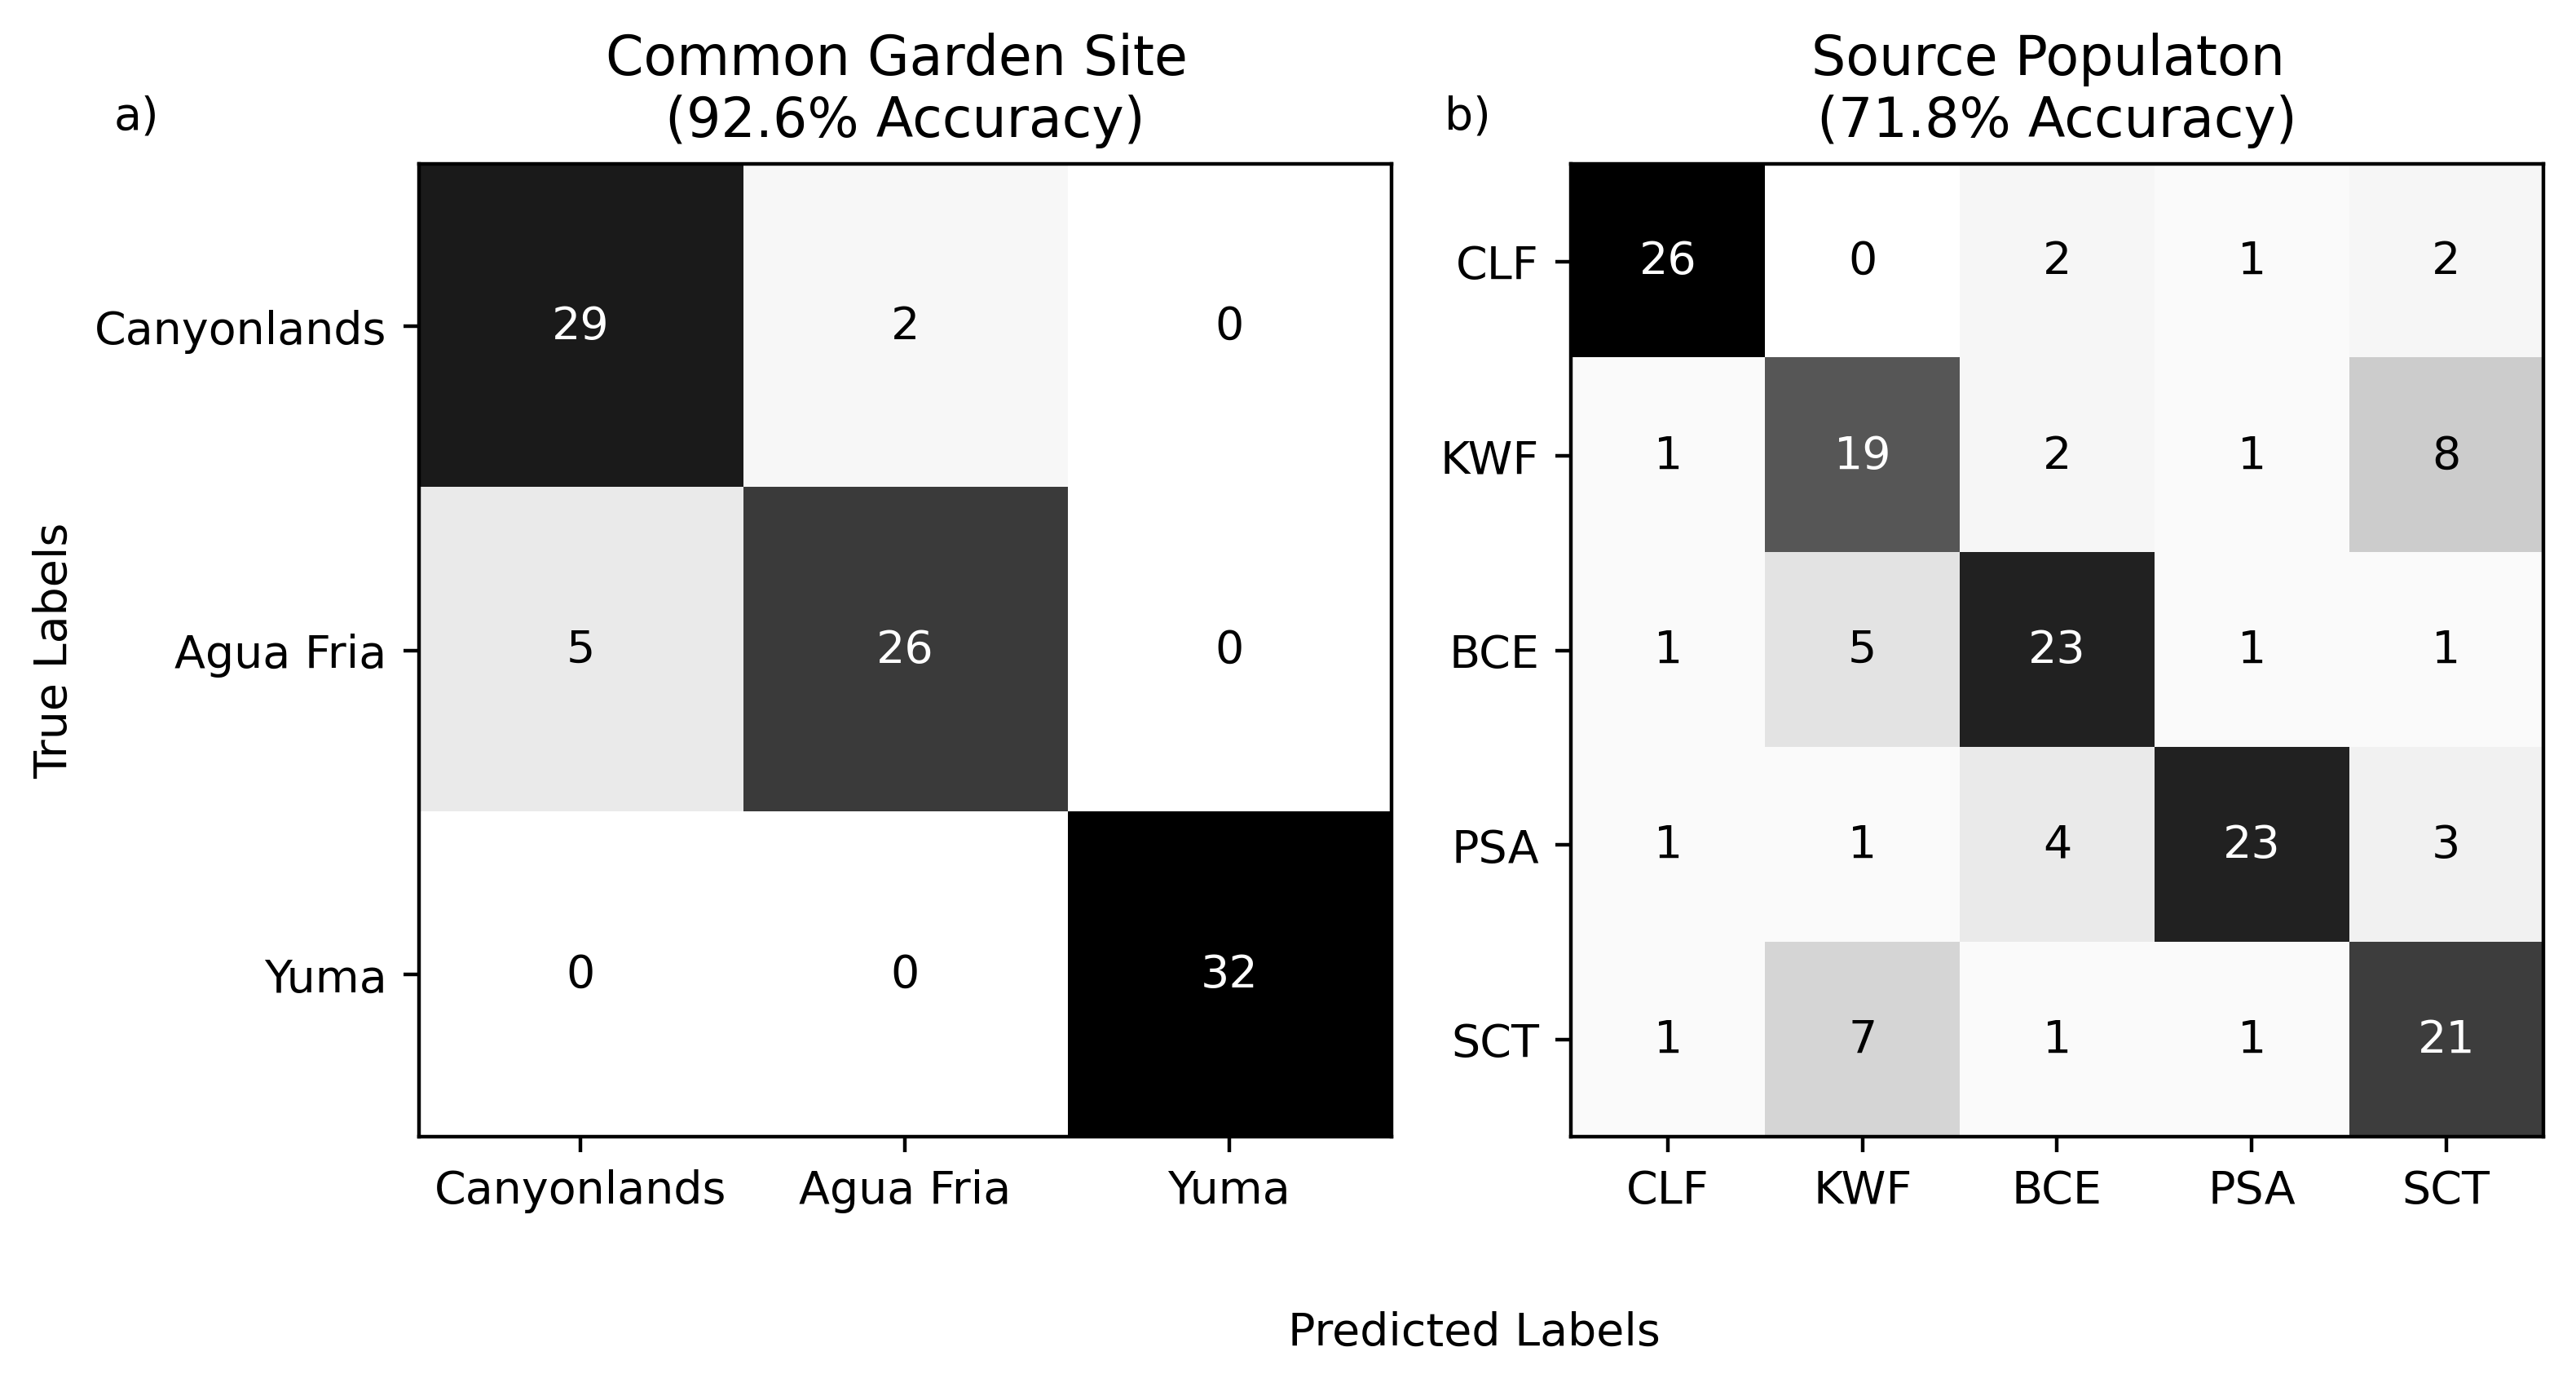

In [176]:
# Create confusion matrix
fig, ax = plt.subplots(1,2, figsize = (8,16), dpi = 400)
sub_pops = ['CLF', 'KWF', 'BCE', 'PSA', 'SCT']

colorbar = False
cmap = "Greys"

cm = pd.DataFrame(confusion_matrix(pop_true, pop_pred), columns = np.unique(pop_true), index = np.unique(pop_true))
cm = cm.reindex(columns=['CLF','KWF', 'BCE',  'PSA', 'SCT'], index = ['CLF','KWF', 'BCE',  'PSA', 'SCT'])

metrics.ConfusionMatrixDisplay(confusion_matrix = np.array(cm), display_labels=sub_pops).plot(
    include_values=True, cmap=cmap,  colorbar=colorbar, ax = ax[1])

metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(gard_true, gard_pred), display_labels=['Canyonlands', 'Agua Fria','Yuma']).plot(
    include_values=True, cmap=cmap,  colorbar=colorbar, ax = ax[0])

ax[1].set_ylabel('')
ax[0].set_ylabel('True Labels')
ax[0].set_title(f'Common Garden Site \n({np.round(gard_acc*100,1)}% Accuracy)')
ax[1].set_title(f'Source Populaton \n({np.round(pop_acc*100,1)}% Accuracy)')

ax[1].set_xlabel('')
ax[0].set_xlabel('')
fig.text(.5,.367,'Predicted Labels')

fig.text(0.05,.6,'a)')
fig.text(.56,.6,'b)')

fig.tight_layout()

In [177]:
# Calculate model metrics for Garden
c = confusion_matrix(gard_true, gard_pred)

FP = c.sum(axis=0) - np.diag(c)  
FN = c.sum(axis=1) - np.diag(c)
TP = np.diag(c)
TN = c.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [171]:
# Calculate model metrics for Population
c = confusion_matrix(pop_true, pop_pred)

FP = c.sum(axis=0) - np.diag(c)  
FN = c.sum(axis=1) - np.diag(c)
TP = np.diag(c)
TN = c.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [ ]:
# Train and test models on different gardens
def svm_reciprocal(data_in, garden):

    training = data_in[data_in.Garden != garden]
    testing = data_in[data_in.Garden == garden]

    

    # Scale Data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(training.iloc[:,2:-1])
    
    tuned_parameters = [
        {"kernel": ["rbf"], "gamma": [10000., 1000., 100., 10., 1., 1e-1, 1e-2, 1e-3, 1e-4], "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]},
    ]

    clf = GridSearchCV(SVC(probability=True), tuned_parameters, scoring="accuracy")
    clf.fit(scaled_data, training.pop_code)

    scaler = StandardScaler()
    y_true, y_pred = testing.pop_code, clf.predict(scaler.fit_transform(testing.iloc[:,2:-1]))

    print("Accuracy:",metrics.accuracy_score(y_true, y_pred))
    acc = metrics.accuracy_score(y_true, y_pred)
        
    return acc

In [186]:
svm_reciprocal(subset_data_pops, 'Agua Fria')

Accuracy: 0.3279569892473118


0.3279569892473118

In [200]:
svm_reciprocal(subset_data_pops, 'Yuma')

Accuracy: 0.375


0.375

In [188]:
svm_reciprocal(subset_data_pops, 'Canyonlands ')

Accuracy: 0.36


0.36

# Heritability

In [ ]:
# Calculating broad sense heritability via variance partitioning. Code adapted from Eleanor Thompson

# The code below was adapted into a parallell processing to perform multiple iterations and obtain a bootstrapped confidence interval

In [214]:
data_noY = data_means[data_means.Garden != 'Yuma']

residual = []
garden = []
clone = []
geno = []
pop = []
ecotype = []

for i, ch in enumerate(range(400,2450)):
    
    Allspecs = data_noY[str(ch)]
    Cottonwood = data_noY.iloc[:,np.append(np.arange(0,6),2057)]
    Cottonwood['specs'] = Allspecs
    model = Lmer('specs ~ (1|ecotype/pop_code/g/n)+(1|Garden)', data=Cottonwood)
    model.fit(REML=True);
    
    residual.__iadd__([np.square(model.ranef_var['Std']['Residual'])])
    garden.__iadd__([np.square(model.ranef_var['Std']['Garden'])])
    ecotype.__iadd__([np.square(model.ranef_var['Std']['ecotype'])])
    clone.__iadd__([np.square(model.ranef_var['Std']['n:(g:(pop_code:ecotype))'])])
    geno.__iadd__([np.square(model.ranef_var['Std']['g:(pop_code:ecotype)'])])
    pop.__iadd__([np.square(model.ranef_var['Std']['pop_code:ecotype'])])
    
    
    
residual = np.array(residual)
garden = np.array(garden)
clone = np.array(clone)
pop = np.array(pop)
geno = np.array(geno)
ecotype = np.array(ecotype)

/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1474.287 	 AIC: -2934.573

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.009
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.007
Residual                               0.0  0.019

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1473.766 	 AIC: -2933.532

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.009
pop_code:ecotype          (Intercept)  0.0  0.009
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.006
Residual                               0.0  0.018

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1473.404 	 AIC: -2932.809

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.019
g:(pop_code:ecotype)      (Intercept)  0.0  0.010
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.006
Residual                               0.0  0.018

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1468.192 	 AIC: -2922.384

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.010
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.006
Residual                               0.0  0.019

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1465.540 	 AIC: -2917.081

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.017
g:(pop_code:ecotype)      (Intercept)  0.0  0.010
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.006
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1470.420 	 AIC: -2926.841

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.017
g:(pop_code:ecotype)      (Intercept)  0.0  0.010
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.006
Residual                               0.0  0.019

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1458.380 	 AIC: -2902.759

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.017
g:(pop_code:ecotype)      (Intercept)  0.0  0.010
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.006
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1451.214 	 AIC: -2888.428

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.010
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.006
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1452.315 	 AIC: -2890.630

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.010
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.006
Residual                               0.0  0.019

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1454.945 	 AIC: -2895.890

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.011
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.007
Residual                               0.0  0.019

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1453.344 	 AIC: -2892.687

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.011
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.007
Residual                               0.0  0.019

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 1

/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1445.755 	 AIC: -2877.510

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.011
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.007
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1441.819 	 AIC: -2869.639

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.007
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1443.857 	 AIC: -2873.713

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.011
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.008
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1445.276 	 AIC: -2876.552

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.011
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.008
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1442.036 	 AIC: -2870.072

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.011
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.000
Garden                    (Intercept)  0.0  0.008
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00204126 (tol = 0.002, component 1) 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1440.208 	 AIC: -2866.416

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.001
Garden                    (Intercept)  0.0  0.009
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1441.290 	 AIC: -2868.581

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.002
Garden                    (Intercept)  0.0  0.009
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1442.093 	 AIC: -2870.186

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.002
Garden                    (Intercept)  0.0  0.010
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1438.870 	 AIC: -2863.741

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.018
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.002
Garden                    (Intercept)  0.0  0.009
Residual                               0.0  0.020

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1435.783 	 AIC: -2857.567

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.017
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.003
Garden                    (Intercept)  0.0  0.010
Residual                               0.0  0.021

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1437.380 	 AIC: -2860.760

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.017
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.003
Garden                    (Intercept)  0.0  0.011
Residual                               0.0  0.021

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1439.913 	 AIC: -2865.826

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.017
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.003
Garden                    (Intercept)  0.0  0.011
Residual                               0.0  0.021

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1435.113 	 AIC: -2856.226

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.017
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.004
Garden                    (Intercept)  0.0  0.011
Residual                               0.0  0.021

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1433.817 	 AIC: -2853.635

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.017
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.005
Garden                    (Intercept)  0.0  0.011
Residual                               0.0  0.021

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1432.682 	 AIC: -2851.364

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.016
g:(pop_code:ecotype)      (Intercept)  0.0  0.013
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.005
Garden                    (Intercept)  0.0  0.012
Residual                               0.0  0.021

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1430.353 	 AIC: -2846.706

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.016
g:(pop_code:ecotype)      (Intercept)  0.0  0.013
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.006
Garden                    (Intercept)  0.0  0.012
Residual                               0.0  0.022

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1430.918 	 AIC: -2847.836

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.016
g:(pop_code:ecotype)      (Intercept)  0.0  0.012
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.006
Garden                    (Intercept)  0.0  0.013
Residual                               0.0  0.022

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1430.164 	 AIC: -2846.327

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.016
g:(pop_code:ecotype)      (Intercept)  0.0  0.013
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.006
Garden                    (Intercept)  0.0  0.013
Residual                               0.0  0.022

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1427.608 	 AIC: -2841.216

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.016
g:(pop_code:ecotype)      (Intercept)  0.0  0.013
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.007
Garden                    (Intercept)  0.0  0.013
Residual                               0.0  0.022

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1424.602 	 AIC: -2835.204

Random effects:

                                 Name  Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.0  0.015
g:(pop_code:ecotype)      (Intercept)  0.0  0.013
pop_code:ecotype          (Intercept)  0.0  0.010
ecotype                   (Intercept)  0.0  0.007
Garden                    (Intercept)  0.0  0.014
Residual                               0.0  0.022

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1422.543 	 AIC: -2831.087

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.015
g:(pop_code:ecotype)      (Intercept)  0.000  0.013
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.007
Garden                    (Intercept)  0.000  0.014
Residual                               0.001  0.022

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_cod

/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1418.658 	 AIC: -2823.316

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.015
g:(pop_code:ecotype)      (Intercept)  0.000  0.013
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.008
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.023

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1417.814 	 AIC: -2821.627

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.015
g:(pop_code:ecotype)      (Intercept)  0.000  0.013
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.008
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.023

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1415.932 	 AIC: -2817.863

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.015
g:(pop_code:ecotype)      (Intercept)  0.000  0.013
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.009
Garden                    (Intercept)  0.000  0.016
Residual                               0.001  0.023

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1411.698 	 AIC: -2809.396

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.015
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.009
Garden                    (Intercept)  0.000  0.016
Residual                               0.001  0.023

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1406.993 	 AIC: -2799.986

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.009
Garden                    (Intercept)  0.000  0.016
Residual                               0.001  0.024

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1408.598 	 AIC: -2803.196

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.010
Garden                    (Intercept)  0.000  0.017
Residual                               0.001  0.023

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1406.168 	 AIC: -2798.336

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.010
Garden                    (Intercept)  0.000  0.017
Residual                               0.001  0.024

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1401.820 	 AIC: -2789.639

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.010
Garden                    (Intercept)  0.000  0.017
Residual                               0.001  0.024

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1399.631 	 AIC: -2785.261

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.010
Garden                    (Intercept)  0.000  0.017
Residual                               0.001  0.024

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1396.930 	 AIC: -2779.860

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.010
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.024

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1394.200 	 AIC: -2774.400

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.010
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.024

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1391.870 	 AIC: -2769.740

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.025

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1389.871 	 AIC: -2765.742

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.025

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1388.335 	 AIC: -2762.670

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.025

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1385.845 	 AIC: -2757.689

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.025

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00331811 (tol = 0.002, component 1) 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1382.445 	 AIC: -2750.889

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.025

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1380.328 	 AIC: -2746.656

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.025

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1376.922 	 AIC: -2739.844

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.026

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1374.302 	 AIC: -2734.604

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.026

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1373.948 	 AIC: -2733.895

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.026

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1369.876 	 AIC: -2725.752

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.026

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1368.254 	 AIC: -2722.507

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.026

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1368.655 	 AIC: -2723.309

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.026

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1366.705 	 AIC: -2719.411

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.026

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1365.238 	 AIC: -2716.476

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.026

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1364.232 	 AIC: -2714.463

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1363.250 	 AIC: -2712.500

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1361.344 	 AIC: -2708.687

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1359.636 	 AIC: -2705.271

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1358.599 	 AIC: -2703.198

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1358.182 	 AIC: -2702.364

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1356.813 	 AIC: -2699.626

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1356.099 	 AIC: -2698.199

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1356.111 	 AIC: -2698.222

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1355.740 	 AIC: -2697.479

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1354.797 	 AIC: -2695.593

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1354.299 	 AIC: -2694.598

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1354.428 	 AIC: -2694.855

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_cod

/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1352.664 	 AIC: -2691.329

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1352.754 	 AIC: -2691.508

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1353.404 	 AIC: -2692.809

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1353.493 	 AIC: -2692.985

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1352.702 	 AIC: -2691.403

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1351.904 	 AIC: -2689.808

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1352.599 	 AIC: -2691.198

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1353.147 	 AIC: -2692.295

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1352.606 	 AIC: -2691.211

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.021
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1351.228 	 AIC: -2688.455

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1351.167 	 AIC: -2688.333

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1350.688 	 AIC: -2687.376

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1349.164 	 AIC: -2684.327

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1346.841 	 AIC: -2679.683

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1346.176 	 AIC: -2678.352

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1344.953 	 AIC: -2675.906

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1342.634 	 AIC: -2671.268

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1340.393 	 AIC: -2666.786

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.010
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1338.825 	 AIC: -2663.650

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.010
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.029

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1336.204 	 AIC: -2658.408

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.010
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.029

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1332.036 	 AIC: -2650.071

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.010
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.029

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1329.408 	 AIC: -2644.816

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.010
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.029

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1325.399 	 AIC: -2636.798

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.009
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.022
Residual                               0.001  0.029

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1320.462 	 AIC: -2626.924

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.009
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.022
Residual                               0.001  0.030

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1316.006 	 AIC: -2618.013

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.008
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.022
Residual                               0.001  0.030

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1310.906 	 AIC: -2607.813

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.008
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.022
Residual                               0.001  0.030

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1305.079 	 AIC: -2596.159

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.008
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.022
Residual                               0.001  0.031

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1298.593 	 AIC: -2583.186

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.007
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.001  0.031

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1291.639 	 AIC: -2569.277

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.006
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.001  0.032

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1283.736 	 AIC: -2553.472

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.005
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.001  0.032

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1274.918 	 AIC: -2535.836

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.003
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.001  0.033

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1265.245 	 AIC: -2516.490

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.001  0.034

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1254.556 	 AIC: -2495.111

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.001  0.034

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1242.171 	 AIC: -2470.343

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.001  0.035

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1227.906 	 AIC: -2441.812

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.015
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.001  0.035

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1211.875 	 AIC: -2409.749

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.015
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.001  0.036

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Group

/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1174.550 	 AIC: -2335.101

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.022
pop_code:ecotype          (Intercept)  0.000  0.016
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.001  0.038

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1153.364 	 AIC: -2292.728

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.023
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.001  0.023
Residual                               0.002  0.039

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1131.394 	 AIC: -2248.788

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.023
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.001  0.023
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Group

/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1083.790 	 AIC: -2153.580

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.001  0.023
Residual                               0.002  0.044

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1058.541 	 AIC: -2103.082

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.026
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.001  0.023
Residual                               0.002  0.045

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1032.322 	 AIC: -2050.645

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.027
pop_code:ecotype          (Intercept)  0.000  0.020
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.001  0.022
Residual                               0.002  0.047

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1005.760 	 AIC: -1997.521

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.028
pop_code:ecotype          (Intercept)  0.000  0.021
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.022
Residual                               0.002  0.049

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 978.958 	 AIC: -1943.917

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.029
pop_code:ecotype          (Intercept)  0.000  0.022
ecotype                   (Intercept)  0.000  0.015
Garden                    (Intercept)  0.000  0.022
Residual                               0.003  0.051

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 951.766 	 AIC: -1889.533

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.030
pop_code:ecotype          (Intercept)  0.001  0.022
ecotype                   (Intercept)  0.000  0.015
Garden                    (Intercept)  0.000  0.022
Residual                               0.003  0.053

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 925.533 	 AIC: -1837.066

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.031
pop_code:ecotype          (Intercept)  0.001  0.023
ecotype                   (Intercept)  0.000  0.015
Garden                    (Intercept)  0.000  0.021
Residual                               0.003  0.055

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 899.885 	 AIC: -1785.769

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.024
ecotype                   (Intercept)  0.000  0.015
Garden                    (Intercept)  0.000  0.021
Residual                               0.003  0.057

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 874.697 	 AIC: -1735.394

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.033
pop_code:ecotype          (Intercept)  0.001  0.025
ecotype                   (Intercept)  0.000  0.016
Garden                    (Intercept)  0.000  0.020
Residual                               0.004  0.059

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 850.683 	 AIC: -1687.367

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.034
pop_code:ecotype          (Intercept)  0.001  0.026
ecotype                   (Intercept)  0.000  0.016
Garden                    (Intercept)  0.000  0.020
Residual                               0.004  0.062

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 827.929 	 AIC: -1641.857

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.035
pop_code:ecotype          (Intercept)  0.001  0.027
ecotype                   (Intercept)  0.000  0.016
Garden                    (Intercept)  0.000  0.019
Residual                               0.004  0.064

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 806.748 	 AIC: -1599.497

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.036
pop_code:ecotype          (Intercept)  0.001  0.028
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.019
Residual                               0.004  0.066

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 787.325 	 AIC: -1560.651

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.037
pop_code:ecotype          (Intercept)  0.001  0.029
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.068

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 768.906 	 AIC: -1523.813

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.038
pop_code:ecotype          (Intercept)  0.001  0.030
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.070

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 751.739 	 AIC: -1489.478

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.039
pop_code:ecotype          (Intercept)  0.001  0.031
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.017
Residual                               0.005  0.072

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 735.975 	 AIC: -1457.950

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.039
pop_code:ecotype          (Intercept)  0.001  0.032
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.016
Residual                               0.005  0.073

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 721.602 	 AIC: -1429.205

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.040
pop_code:ecotype          (Intercept)  0.001  0.032
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.016
Residual                               0.006  0.075

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Model failed to converge with max|grad| = 0.00244767 (tol = 0.002, component 1) 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 708.002 	 AIC: -1402.003

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.040
pop_code:ecotype          (Intercept)  0.001  0.033
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.015
Residual                               0.006  0.077

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 695.502 	 AIC: -1377.004

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.041
pop_code:ecotype          (Intercept)  0.001  0.034
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.015
Residual                               0.006  0.078

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 684.326 	 AIC: -1354.653

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.041
pop_code:ecotype          (Intercept)  0.001  0.035
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.014
Residual                               0.006  0.079

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 673.725 	 AIC: -1333.451

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.042
pop_code:ecotype          (Intercept)  0.001  0.035
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.013
Residual                               0.007  0.081

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 664.145 	 AIC: -1314.290

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.042
pop_code:ecotype          (Intercept)  0.001  0.036
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.013
Residual                               0.007  0.082

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 655.497 	 AIC: -1296.995

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.042
pop_code:ecotype          (Intercept)  0.001  0.036
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.012
Residual                               0.007  0.083

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 647.433 	 AIC: -1280.865

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.043
pop_code:ecotype          (Intercept)  0.001  0.037
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.012
Residual                               0.007  0.084

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 640.025 	 AIC: -1266.049

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.043
pop_code:ecotype          (Intercept)  0.001  0.038
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.011
Residual                               0.007  0.085

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 633.186 	 AIC: -1252.372

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.043
pop_code:ecotype          (Intercept)  0.001  0.038
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.011
Residual                               0.007  0.086

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 626.848 	 AIC: -1239.695

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.043
pop_code:ecotype          (Intercept)  0.001  0.038
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.011
Residual                               0.008  0.087

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 621.024 	 AIC: -1228.049

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.002  0.039
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.010
Residual                               0.008  0.088

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 615.559 	 AIC: -1217.118

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.002  0.039
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.010
Residual                               0.008  0.088

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 610.385 	 AIC: -1206.770

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.002  0.040
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.010
Residual                               0.008  0.089

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 605.475 	 AIC: -1196.950

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.002  0.040
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.010
Residual                               0.008  0.090

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 600.751 	 AIC: -1187.501

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.002  0.040
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.010
Residual                               0.008  0.090

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 596.149 	 AIC: -1178.298

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.002  0.041
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.010
Residual                               0.008  0.091

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.02331 (tol = 0.002, component 1) 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 591.773 	 AIC: -1169.545

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.001
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.041
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.010
Residual                               0.008  0.092

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 587.837 	 AIC: -1161.675

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.041
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.010
Residual                               0.009  0.092

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 584.176 	 AIC: -1154.351

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.041
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.010
Residual                               0.009  0.093

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 580.922 	 AIC: -1147.843

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.042
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.010
Residual                               0.009  0.093

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 578.262 	 AIC: -1142.523

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.042
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.010
Residual                               0.009  0.094

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 576.402 	 AIC: -1138.804

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.042
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.010
Residual                               0.009  0.094

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 575.248 	 AIC: -1136.496

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.042
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.010
Residual                               0.009  0.094

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 574.799 	 AIC: -1135.598

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.042
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.011
Residual                               0.009  0.094

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 575.123 	 AIC: -1136.246

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.042
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.011
Residual                               0.009  0.094

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 576.461 	 AIC: -1138.923

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.042
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.011
Residual                               0.009  0.094

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 578.707 	 AIC: -1143.415

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.042
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.011
Residual                               0.009  0.094

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 581.689 	 AIC: -1149.378

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.002  0.042
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.011
Residual                               0.009  0.093

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 585.197 	 AIC: -1156.394

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.002  0.041
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.012
Residual                               0.009  0.093

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 589.418 	 AIC: -1164.837

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.002  0.041
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.012
Residual                               0.009  0.092

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 594.263 	 AIC: -1174.527

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.002  0.040
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.012
Residual                               0.008  0.092

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 599.587 	 AIC: -1185.174

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.043
pop_code:ecotype          (Intercept)  0.002  0.040
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.012
Residual                               0.008  0.091

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 605.331 	 AIC: -1196.662

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.043
pop_code:ecotype          (Intercept)  0.002  0.039
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.013
Residual                               0.008  0.090

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 611.716 	 AIC: -1209.432

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.043
pop_code:ecotype          (Intercept)  0.001  0.039
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.013
Residual                               0.008  0.089

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 618.781 	 AIC: -1223.562

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.042
pop_code:ecotype          (Intercept)  0.001  0.038
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.013
Residual                               0.008  0.088

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 626.414 	 AIC: -1238.827

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.042
pop_code:ecotype          (Intercept)  0.001  0.037
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.013
Residual                               0.008  0.087

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 634.717 	 AIC: -1255.434

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.042
pop_code:ecotype          (Intercept)  0.001  0.036
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.014
Residual                               0.007  0.086

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 643.771 	 AIC: -1273.542

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.041
pop_code:ecotype          (Intercept)  0.001  0.036
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.014
Residual                               0.007  0.085

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 653.560 	 AIC: -1293.120

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.041
pop_code:ecotype          (Intercept)  0.001  0.035
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.014
Residual                               0.007  0.084

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 663.852 	 AIC: -1313.704

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.040
pop_code:ecotype          (Intercept)  0.001  0.034
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.015
Residual                               0.007  0.083

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 674.494 	 AIC: -1334.988

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.040
pop_code:ecotype          (Intercept)  0.001  0.034
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.015
Residual                               0.007  0.081

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 685.226 	 AIC: -1356.452

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.039
pop_code:ecotype          (Intercept)  0.001  0.033
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.015
Residual                               0.006  0.080

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 695.783 	 AIC: -1377.567

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.039
pop_code:ecotype          (Intercept)  0.001  0.032
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.016
Residual                               0.006  0.079

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 706.065 	 AIC: -1398.129

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.038
pop_code:ecotype          (Intercept)  0.001  0.032
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.017
Residual                               0.006  0.077

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 715.951 	 AIC: -1417.901

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.038
pop_code:ecotype          (Intercept)  0.001  0.031
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.017
Residual                               0.006  0.076

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 725.391 	 AIC: -1436.781

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.037
pop_code:ecotype          (Intercept)  0.001  0.031
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.017
Residual                               0.006  0.075

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 734.372 	 AIC: -1454.744

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.037
pop_code:ecotype          (Intercept)  0.001  0.031
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.018
Residual                               0.006  0.074

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 742.924 	 AIC: -1471.847

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.036
pop_code:ecotype          (Intercept)  0.001  0.030
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.073

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 750.866 	 AIC: -1487.732

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.036
pop_code:ecotype          (Intercept)  0.001  0.030
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.072

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 758.152 	 AIC: -1502.303

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.035
pop_code:ecotype          (Intercept)  0.001  0.030
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.072

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 765.438 	 AIC: -1516.876

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.035
pop_code:ecotype          (Intercept)  0.001  0.029
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.071

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 772.227 	 AIC: -1530.454

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.035
pop_code:ecotype          (Intercept)  0.001  0.029
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.070

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 778.553 	 AIC: -1543.106

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.035
pop_code:ecotype          (Intercept)  0.001  0.028
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.070

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 784.819 	 AIC: -1555.639

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.034
pop_code:ecotype          (Intercept)  0.001  0.028
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.069

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 790.630 	 AIC: -1567.260

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.034
pop_code:ecotype          (Intercept)  0.001  0.027
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.068

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 795.953 	 AIC: -1577.906

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.034
pop_code:ecotype          (Intercept)  0.001  0.027
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.068

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 800.963 	 AIC: -1587.925

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.034
pop_code:ecotype          (Intercept)  0.001  0.027
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.005  0.067

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 806.142 	 AIC: -1598.283

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.033
pop_code:ecotype          (Intercept)  0.001  0.026
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.017
Residual                               0.004  0.067

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 811.212 	 AIC: -1608.424

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.033
pop_code:ecotype          (Intercept)  0.001  0.026
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.017
Residual                               0.004  0.066

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 815.918 	 AIC: -1617.837

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.033
pop_code:ecotype          (Intercept)  0.001  0.026
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.066

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 820.026 	 AIC: -1626.051

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.033
pop_code:ecotype          (Intercept)  0.001  0.025
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.065

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 823.432 	 AIC: -1632.864

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.033
pop_code:ecotype          (Intercept)  0.001  0.025
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.065

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 826.417 	 AIC: -1638.834

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.033
pop_code:ecotype          (Intercept)  0.001  0.025
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.065

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 829.135 	 AIC: -1644.269

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.025
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.065

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 831.596 	 AIC: -1649.193

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.025
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.064

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 833.756 	 AIC: -1653.512

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.025
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.019
Residual                               0.004  0.064

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 836.145 	 AIC: -1658.291

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.025
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.019
Residual                               0.004  0.064

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 839.145 	 AIC: -1664.290

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.025
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.064

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 842.333 	 AIC: -1670.666

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.024
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.063

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 845.775 	 AIC: -1677.550

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.024
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.063

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 849.661 	 AIC: -1685.322

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.024
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.063

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 854.216 	 AIC: -1694.432

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.024
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.062

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 859.175 	 AIC: -1704.350

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.031
pop_code:ecotype          (Intercept)  0.001  0.023
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.018
Residual                               0.004  0.062

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 864.983 	 AIC: -1715.967

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.031
pop_code:ecotype          (Intercept)  0.001  0.023
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.019
Residual                               0.004  0.061

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 871.811 	 AIC: -1729.622

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.031
pop_code:ecotype          (Intercept)  0.001  0.023
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.019
Residual                               0.004  0.061

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 879.179 	 AIC: -1744.359

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.030
pop_code:ecotype          (Intercept)  0.001  0.023
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.019
Residual                               0.004  0.060

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 887.461 	 AIC: -1760.921

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.030
pop_code:ecotype          (Intercept)  0.000  0.022
ecotype                   (Intercept)  0.000  0.016
Garden                    (Intercept)  0.000  0.019
Residual                               0.003  0.059

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 896.449 	 AIC: -1778.898

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.030
pop_code:ecotype          (Intercept)  0.000  0.022
ecotype                   (Intercept)  0.000  0.016
Garden                    (Intercept)  0.000  0.019
Residual                               0.003  0.058

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 905.772 	 AIC: -1797.544

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.029
pop_code:ecotype          (Intercept)  0.000  0.022
ecotype                   (Intercept)  0.000  0.016
Garden                    (Intercept)  0.000  0.019
Residual                               0.003  0.058

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 915.498 	 AIC: -1816.996

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.029
pop_code:ecotype          (Intercept)  0.000  0.022
ecotype                   (Intercept)  0.000  0.016
Garden                    (Intercept)  0.000  0.019
Residual                               0.003  0.057

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 925.337 	 AIC: -1836.673

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.029
pop_code:ecotype          (Intercept)  0.000  0.021
ecotype                   (Intercept)  0.000  0.015
Garden                    (Intercept)  0.000  0.019
Residual                               0.003  0.056

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 935.209 	 AIC: -1856.418

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.028
pop_code:ecotype          (Intercept)  0.000  0.021
ecotype                   (Intercept)  0.000  0.015
Garden                    (Intercept)  0.000  0.019
Residual                               0.003  0.055

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 945.237 	 AIC: -1876.473

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.028
pop_code:ecotype          (Intercept)  0.000  0.021
ecotype                   (Intercept)  0.000  0.015
Garden                    (Intercept)  0.000  0.019
Residual                               0.003  0.054

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 954.970 	 AIC: -1895.940

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.027
pop_code:ecotype          (Intercept)  0.000  0.020
ecotype                   (Intercept)  0.000  0.015
Garden                    (Intercept)  0.000  0.019
Residual                               0.003  0.054

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 964.539 	 AIC: -1915.079

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.027
pop_code:ecotype          (Intercept)  0.000  0.020
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.003  0.053

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 973.981 	 AIC: -1933.963

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.027
pop_code:ecotype          (Intercept)  0.000  0.020
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.003  0.052

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 982.746 	 AIC: -1951.491

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.026
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.003  0.051

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 990.776 	 AIC: -1967.552

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.026
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.003  0.051

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 998.157 	 AIC: -1982.313

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.026
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.003  0.050

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1005.033 	 AIC: -1996.067

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.026
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.050

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1010.898 	 AIC: -2007.797

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.049

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1016.067 	 AIC: -2018.133

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.049

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1020.671 	 AIC: -2027.342

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.049

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1024.330 	 AIC: -2034.659

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.048

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1027.475 	 AIC: -2040.950

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.048

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1030.057 	 AIC: -2046.114

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.048

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1031.963 	 AIC: -2049.925

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.048

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1033.477 	 AIC: -2052.954

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.048

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1034.619 	 AIC: -2055.239

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.048

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1035.499 	 AIC: -2056.998

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.047

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1036.334 	 AIC: -2058.667

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.047

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1037.536 	 AIC: -2061.071

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.047

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1039.321 	 AIC: -2064.641

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.024
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.047

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1041.793 	 AIC: -2069.587

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.024
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.047

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1044.875 	 AIC: -2075.749

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.024
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.047

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1049.332 	 AIC: -2084.664

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.024
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.047

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1055.003 	 AIC: -2096.006

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.024
pop_code:ecotype          (Intercept)  0.000  0.016
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.046

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1061.332 	 AIC: -2108.664

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.024
pop_code:ecotype          (Intercept)  0.000  0.016
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.046

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1068.842 	 AIC: -2123.683

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.024
pop_code:ecotype          (Intercept)  0.000  0.015
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.045

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1077.335 	 AIC: -2140.669

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.023
pop_code:ecotype          (Intercept)  0.000  0.015
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.045

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Group

/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1095.968 	 AIC: -2177.936

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.023
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.043

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1106.341 	 AIC: -2198.682

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.023
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.043

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1117.335 	 AIC: -2220.670

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.022
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1128.468 	 AIC: -2242.936

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.022
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1139.480 	 AIC: -2264.960

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.022
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1150.570 	 AIC: -2287.140

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1161.251 	 AIC: -2308.503

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.039

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1170.634 	 AIC: -2327.267

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.020
Residual                               0.002  0.039

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1179.825 	 AIC: -2345.650

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.038

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1188.489 	 AIC: -2362.978

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.038

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1196.454 	 AIC: -2378.908

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.037

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1204.346 	 AIC: -2394.692

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.020
Residual                               0.001  0.037

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1212.533 	 AIC: -2411.067

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.037

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1221.234 	 AIC: -2428.469

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.036

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1230.551 	 AIC: -2447.103

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.036

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1240.679 	 AIC: -2467.357

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.035

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1251.401 	 AIC: -2488.802

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.035

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1262.572 	 AIC: -2511.143

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.034

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1274.142 	 AIC: -2534.283

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.033

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1285.525 	 AIC: -2557.049

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.012
Garden                    (Intercept)  0.000  0.019
Residual                               0.001  0.033

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1296.542 	 AIC: -2579.085

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.032

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1307.085 	 AIC: -2600.170

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.032

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1316.881 	 AIC: -2619.762

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.031

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1325.820 	 AIC: -2637.640

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.002
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.031

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1333.988 	 AIC: -2653.976

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.004
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.030

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1341.512 	 AIC: -2669.025

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.006
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.030

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1347.922 	 AIC: -2681.844

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.007
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.029

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1353.439 	 AIC: -2692.878

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.008
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.018
Residual                               0.001  0.029

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1358.237 	 AIC: -2702.474

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.008
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.017
Residual                               0.001  0.029

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1362.196 	 AIC: -2710.391

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.009
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.017
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1365.345 	 AIC: -2716.691

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.009
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.017
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1367.884 	 AIC: -2721.768

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.010
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.017
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1369.933 	 AIC: -2725.866

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.010
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.017
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1370.974 	 AIC: -2727.948

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.010
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.017
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1371.362 	 AIC: -2728.725

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.016
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1371.222 	 AIC: -2728.445

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.016
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1370.380 	 AIC: -2726.761

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.016
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1368.565 	 AIC: -2723.130

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.016
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1365.490 	 AIC: -2716.981

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.016
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1361.062 	 AIC: -2708.124

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1355.543 	 AIC: -2697.086

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.027

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1348.419 	 AIC: -2682.838

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1339.449 	 AIC: -2664.897

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.028

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1328.354 	 AIC: -2642.707

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.029

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1314.358 	 AIC: -2614.715

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.010
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.030

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1296.275 	 AIC: -2578.550

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.009
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.031

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1272.654 	 AIC: -2531.307

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.007
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.033

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1241.786 	 AIC: -2469.571

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.035

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1202.054 	 AIC: -2390.108

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.001  0.037

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_cod

/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1095.112 	 AIC: -2176.223

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.023
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.002  0.043

No random effect correlations specified

Fixed effects:



/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1030.678 	 AIC: -2047.356

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.000  0.020
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.002  0.048

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 962.783 	 AIC: -1911.566

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.027
pop_code:ecotype          (Intercept)  0.001  0.022
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.015
Residual                               0.003  0.053

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 894.299 	 AIC: -1774.598

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.029
pop_code:ecotype          (Intercept)  0.001  0.026
ecotype                   (Intercept)  0.000  0.010
Garden                    (Intercept)  0.000  0.014
Residual                               0.003  0.059

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 827.527 	 AIC: -1641.055

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.029
ecotype                   (Intercept)  0.000  0.009
Garden                    (Intercept)  0.000  0.014
Residual                               0.004  0.065

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 764.255 	 AIC: -1514.511

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.035
pop_code:ecotype          (Intercept)  0.001  0.032
ecotype                   (Intercept)  0.000  0.008
Garden                    (Intercept)  0.000  0.014
Residual                               0.005  0.071

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 705.511 	 AIC: -1397.023

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.037
pop_code:ecotype          (Intercept)  0.001  0.036
ecotype                   (Intercept)  0.000  0.007
Garden                    (Intercept)  0.000  0.013
Residual                               0.006  0.078

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 651.894 	 AIC: -1289.788

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.040
pop_code:ecotype          (Intercept)  0.002  0.039
ecotype                   (Intercept)  0.000  0.007
Garden                    (Intercept)  0.000  0.013
Residual                               0.007  0.084

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 603.610 	 AIC: -1193.220

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.043
pop_code:ecotype          (Intercept)  0.002  0.043
ecotype                   (Intercept)  0.000  0.006
Garden                    (Intercept)  0.000  0.012
Residual                               0.008  0.090

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 560.592 	 AIC: -1107.185

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.045
pop_code:ecotype          (Intercept)  0.002  0.046
ecotype                   (Intercept)  0.000  0.006
Garden                    (Intercept)  0.000  0.012
Residual                               0.009  0.096

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 522.856 	 AIC: -1031.711

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.047
pop_code:ecotype          (Intercept)  0.002  0.049
ecotype                   (Intercept)  0.000  0.006
Garden                    (Intercept)  0.000  0.012
Residual                               0.010  0.102

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 490.270 	 AIC: -966.540

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.049
pop_code:ecotype          (Intercept)  0.003  0.051
ecotype                   (Intercept)  0.000  0.007
Garden                    (Intercept)  0.000  0.012
Residual                               0.011  0.107

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 462.380 	 AIC: -910.761

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.051
pop_code:ecotype          (Intercept)  0.003  0.054
ecotype                   (Intercept)  0.000  0.008
Garden                    (Intercept)  0.000  0.012
Residual                               0.012  0.112

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


unable to evaluate scaled gradient 

Model failed to converge: degenerate  Hessian with 1 negative eigenvalues 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 438.979 	 AIC: -863.957

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.052
pop_code:ecotype          (Intercept)  0.003  0.057
ecotype                   (Intercept)  0.000  0.000
Garden                    (Intercept)  0.000  0.012
Residual                               0.013  0.116

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 419.768 	 AIC: -825.536

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.053
pop_code:ecotype          (Intercept)  0.003  0.058
ecotype                   (Intercept)  0.000  0.010
Garden                    (Intercept)  0.000  0.012
Residual                               0.014  0.119

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 404.359 	 AIC: -794.718

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.054
pop_code:ecotype          (Intercept)  0.004  0.059
ecotype                   (Intercept)  0.000  0.011
Garden                    (Intercept)  0.000  0.012
Residual                               0.015  0.122

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 392.556 	 AIC: -771.112

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.055
pop_code:ecotype          (Intercept)  0.004  0.061
ecotype                   (Intercept)  0.000  0.013
Garden                    (Intercept)  0.000  0.012
Residual                               0.015  0.124

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 384.083 	 AIC: -754.166

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.055
pop_code:ecotype          (Intercept)  0.004  0.062
ecotype                   (Intercept)  0.000  0.014
Garden                    (Intercept)  0.000  0.012
Residual                               0.016  0.125

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 378.724 	 AIC: -743.447

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.055
pop_code:ecotype          (Intercept)  0.004  0.062
ecotype                   (Intercept)  0.000  0.015
Garden                    (Intercept)  0.000  0.012
Residual                               0.016  0.127

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 376.378 	 AIC: -738.756

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.055
pop_code:ecotype          (Intercept)  0.004  0.063
ecotype                   (Intercept)  0.000  0.017
Garden                    (Intercept)  0.000  0.012
Residual                               0.016  0.127

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 376.887 	 AIC: -739.774

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.055
pop_code:ecotype          (Intercept)  0.004  0.063
ecotype                   (Intercept)  0.000  0.018
Garden                    (Intercept)  0.000  0.011
Residual                               0.016  0.127

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 380.195 	 AIC: -746.391

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.054
pop_code:ecotype          (Intercept)  0.004  0.062
ecotype                   (Intercept)  0.000  0.019
Garden                    (Intercept)  0.000  0.011
Residual                               0.016  0.126

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 386.294 	 AIC: -758.588

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.054
pop_code:ecotype          (Intercept)  0.004  0.062
ecotype                   (Intercept)  0.000  0.021
Garden                    (Intercept)  0.000  0.011
Residual                               0.016  0.125

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 395.049 	 AIC: -776.099

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.053
pop_code:ecotype          (Intercept)  0.004  0.061
ecotype                   (Intercept)  0.000  0.022
Garden                    (Intercept)  0.000  0.010
Residual                               0.015  0.124

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 406.391 	 AIC: -798.781

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.052
pop_code:ecotype          (Intercept)  0.004  0.060
ecotype                   (Intercept)  0.001  0.023
Garden                    (Intercept)  0.000  0.010
Residual                               0.015  0.122

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 420.302 	 AIC: -826.605

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.003  0.051
pop_code:ecotype          (Intercept)  0.003  0.059
ecotype                   (Intercept)  0.001  0.025
Garden                    (Intercept)  0.000  0.009
Residual                               0.014  0.119

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 436.810 	 AIC: -859.619

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.049
pop_code:ecotype          (Intercept)  0.003  0.058
ecotype                   (Intercept)  0.001  0.026
Garden                    (Intercept)  0.000  0.009
Residual                               0.014  0.117

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 455.809 	 AIC: -897.619

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.048
pop_code:ecotype          (Intercept)  0.003  0.056
ecotype                   (Intercept)  0.001  0.027
Garden                    (Intercept)  0.000  0.008
Residual                               0.013  0.113

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 477.262 	 AIC: -940.523

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.046
pop_code:ecotype          (Intercept)  0.003  0.054
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.008
Residual                               0.012  0.110

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 501.106 	 AIC: -988.213

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.044
pop_code:ecotype          (Intercept)  0.003  0.052
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.007
Residual                               0.011  0.106

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 527.361 	 AIC: -1040.723

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.042
pop_code:ecotype          (Intercept)  0.002  0.050
ecotype                   (Intercept)  0.001  0.032
Garden                    (Intercept)  0.000  0.006
Residual                               0.010  0.102

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 555.899 	 AIC: -1097.799

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.002  0.040
pop_code:ecotype          (Intercept)  0.002  0.047
ecotype                   (Intercept)  0.001  0.033
Garden                    (Intercept)  0.000  0.006
Residual                               0.010  0.098

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 586.580 	 AIC: -1159.159

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.038
pop_code:ecotype          (Intercept)  0.002  0.044
ecotype                   (Intercept)  0.001  0.035
Garden                    (Intercept)  0.000  0.005
Residual                               0.009  0.094

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 619.307 	 AIC: -1224.614

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.036
pop_code:ecotype          (Intercept)  0.002  0.042
ecotype                   (Intercept)  0.001  0.036
Garden                    (Intercept)  0.000  0.005
Residual                               0.008  0.089

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 653.842 	 AIC: -1293.685

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.034
pop_code:ecotype          (Intercept)  0.002  0.039
ecotype                   (Intercept)  0.001  0.038
Garden                    (Intercept)  0.000  0.004
Residual                               0.007  0.085

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 690.078 	 AIC: -1366.157

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.032
pop_code:ecotype          (Intercept)  0.001  0.036
ecotype                   (Intercept)  0.002  0.039
Garden                    (Intercept)  0.000  0.004
Residual                               0.007  0.081

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 727.847 	 AIC: -1441.694

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.030
pop_code:ecotype          (Intercept)  0.001  0.034
ecotype                   (Intercept)  0.002  0.040
Garden                    (Intercept)  0.000  0.003
Residual                               0.006  0.076

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 766.709 	 AIC: -1519.417

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.028
pop_code:ecotype          (Intercept)  0.001  0.031
ecotype                   (Intercept)  0.002  0.041
Garden                    (Intercept)  0.000  0.003
Residual                               0.005  0.072

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 806.645 	 AIC: -1599.289

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.026
pop_code:ecotype          (Intercept)  0.001  0.028
ecotype                   (Intercept)  0.002  0.042
Garden                    (Intercept)  0.000  0.002
Residual                               0.005  0.068

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 847.253 	 AIC: -1680.506

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.025
pop_code:ecotype          (Intercept)  0.001  0.026
ecotype                   (Intercept)  0.002  0.043
Garden                    (Intercept)  0.000  0.002
Residual                               0.004  0.064

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 887.951 	 AIC: -1761.901

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.001  0.023
pop_code:ecotype          (Intercept)  0.001  0.023
ecotype                   (Intercept)  0.002  0.043
Garden                    (Intercept)  0.000  0.001
Residual                               0.004  0.061

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 928.340 	 AIC: -1842.681

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.021
ecotype                   (Intercept)  0.002  0.044
Garden                    (Intercept)  0.000  0.000
Residual                               0.003  0.057

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 968.030 	 AIC: -1922.059

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.002  0.044
Garden                    (Intercept)  0.000  0.000
Residual                               0.003  0.054

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1006.569 	 AIC: -1999.137

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.007
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.016
ecotype                   (Intercept)  0.002  0.044
Garden                    (Intercept)  0.000  0.000
Residual                               0.003  0.051

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1043.460 	 AIC: -2072.919

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.010
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.002  0.044
Garden                    (Intercept)  0.000  0.000
Residual                               0.002  0.048

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1077.452 	 AIC: -2140.904

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.002  0.044
Garden                    (Intercept)  0.000  0.000
Residual                               0.002  0.045

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1108.599 	 AIC: -2203.197

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.002  0.044
Garden                    (Intercept)  0.000  0.000
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1136.698 	 AIC: -2259.396

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.015
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.002  0.043
Garden                    (Intercept)  0.000  0.000
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1160.680 	 AIC: -2307.360

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.016
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.009
ecotype                   (Intercept)  0.002  0.043
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.038

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1180.769 	 AIC: -2347.538

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.017
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.009
ecotype                   (Intercept)  0.002  0.042
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.036

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1197.081 	 AIC: -2380.162

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.017
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.008
ecotype                   (Intercept)  0.002  0.042
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.035

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Group

/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1218.680 	 AIC: -2423.360

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.018
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.009
ecotype                   (Intercept)  0.002  0.040
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.033

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1224.594 	 AIC: -2435.188

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.018
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.009
ecotype                   (Intercept)  0.002  0.040
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.033

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1228.014 	 AIC: -2442.027

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.018
g:(pop_code:ecotype)      (Intercept)  0.000  0.014
pop_code:ecotype          (Intercept)  0.000  0.009
ecotype                   (Intercept)  0.002  0.039
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.033

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1229.339 	 AIC: -2444.679

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.017
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.001  0.038
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.032

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1228.851 	 AIC: -2443.702

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.017
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.010
ecotype                   (Intercept)  0.001  0.038
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.033

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1226.982 	 AIC: -2439.965

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.016
g:(pop_code:ecotype)      (Intercept)  0.000  0.015
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.001  0.037
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.033

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1224.072 	 AIC: -2434.144

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.015
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.001  0.037
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.034

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1220.293 	 AIC: -2426.586

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.014
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.011
ecotype                   (Intercept)  0.001  0.036
Garden                    (Intercept)  0.000  0.000
Residual                               0.001  0.034

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1216.221 	 AIC: -2418.442

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.013
g:(pop_code:ecotype)      (Intercept)  0.000  0.016
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.001  0.036
Garden                    (Intercept)  0.000  0.001
Residual                               0.001  0.035

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1212.038 	 AIC: -2410.076

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.012
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.012
ecotype                   (Intercept)  0.001  0.035
Garden                    (Intercept)  0.000  0.002
Residual                               0.001  0.035

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1207.745 	 AIC: -2401.491

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.011
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.013
ecotype                   (Intercept)  0.001  0.035
Garden                    (Intercept)  0.000  0.002
Residual                               0.001  0.036

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1203.224 	 AIC: -2392.448

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.009
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.001  0.035
Garden                    (Intercept)  0.000  0.003
Residual                               0.001  0.036

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1198.644 	 AIC: -2383.288

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.008
g:(pop_code:ecotype)      (Intercept)  0.000  0.017
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.001  0.034
Garden                    (Intercept)  0.000  0.003
Residual                               0.001  0.037

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1194.189 	 AIC: -2374.378

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.006
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.014
ecotype                   (Intercept)  0.001  0.034
Garden                    (Intercept)  0.000  0.004
Residual                               0.001  0.038

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1190.024 	 AIC: -2366.048

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.001
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.015
ecotype                   (Intercept)  0.001  0.033
Garden                    (Intercept)  0.000  0.004
Residual                               0.001  0.038

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1186.015 	 AIC: -2358.029

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.015
ecotype                   (Intercept)  0.001  0.033
Garden                    (Intercept)  0.000  0.005
Residual                               0.001  0.038

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1182.066 	 AIC: -2350.132

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.015
ecotype                   (Intercept)  0.001  0.033
Garden                    (Intercept)  0.000  0.005
Residual                               0.001  0.039

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1178.276 	 AIC: -2342.551

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.018
pop_code:ecotype          (Intercept)  0.000  0.016
ecotype                   (Intercept)  0.001  0.032
Garden                    (Intercept)  0.000  0.005
Residual                               0.001  0.039

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1175.070 	 AIC: -2336.141

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.016
ecotype                   (Intercept)  0.001  0.032
Garden                    (Intercept)  0.000  0.005
Residual                               0.002  0.039

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1171.993 	 AIC: -2329.986

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.016
ecotype                   (Intercept)  0.001  0.032
Garden                    (Intercept)  0.000  0.006
Residual                               0.002  0.039

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1169.098 	 AIC: -2324.197

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.016
ecotype                   (Intercept)  0.001  0.032
Garden                    (Intercept)  0.000  0.006
Residual                               0.002  0.039

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1166.524 	 AIC: -2319.048

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.001  0.032
Garden                    (Intercept)  0.000  0.006
Residual                               0.002  0.039

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1164.017 	 AIC: -2314.034

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.001  0.032
Garden                    (Intercept)  0.000  0.007
Residual                               0.002  0.039

No random effect correlations specified

Fixed effects:

Model failed to converge with max|grad| = 0.00203016 (tol = 0.002, component 1) 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1161.637 	 AIC: -2309.273

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.001  0.031
Garden                    (Intercept)  0.000  0.007
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1159.527 	 AIC: -2305.054

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.019
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.001  0.031
Garden                    (Intercept)  0.000  0.007
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1157.802 	 AIC: -2301.604

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.001  0.031
Garden                    (Intercept)  0.000  0.007
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1155.911 	 AIC: -2297.822

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.001  0.031
Garden                    (Intercept)  0.000  0.008
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1154.152 	 AIC: -2294.304

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.001  0.031
Garden                    (Intercept)  0.000  0.008
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1152.698 	 AIC: -2291.396

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.017
ecotype                   (Intercept)  0.001  0.031
Garden                    (Intercept)  0.000  0.008
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1151.308 	 AIC: -2288.616

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.031
Garden                    (Intercept)  0.000  0.008
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1149.967 	 AIC: -2285.934

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.008
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1148.708 	 AIC: -2283.416

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.008
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1147.542 	 AIC: -2281.083

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.008
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1146.319 	 AIC: -2278.637

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.009
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1145.224 	 AIC: -2276.447

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.009
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1144.195 	 AIC: -2274.389

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.009
Residual                               0.002  0.040

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1143.039 	 AIC: -2272.077

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.009
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1142.047 	 AIC: -2270.094

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.009
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1141.088 	 AIC: -2268.175

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.009
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1140.080 	 AIC: -2266.159

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.020
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.009
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1139.094 	 AIC: -2264.188

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.030
Garden                    (Intercept)  0.000  0.009
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1138.496 	 AIC: -2262.991

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.009
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1137.894 	 AIC: -2261.788

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1136.953 	 AIC: -2259.906

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1136.245 	 AIC: -2258.490

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1135.432 	 AIC: -2256.864

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.018
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1134.522 	 AIC: -2255.043

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1133.679 	 AIC: -2253.358

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1132.702 	 AIC: -2251.404

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1131.825 	 AIC: -2249.650

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1131.099 	 AIC: -2248.198

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1130.310 	 AIC: -2246.620

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1129.764 	 AIC: -2245.529

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.010
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Group

/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1128.177 	 AIC: -2242.354

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1127.477 	 AIC: -2240.954

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1126.815 	 AIC: -2239.629

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.041

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Group

/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1125.502 	 AIC: -2237.003

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1125.055 	 AIC: -2236.111

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1124.497 	 AIC: -2234.994

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.029
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Group

/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1123.301 	 AIC: -2232.602

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.028
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1122.509 	 AIC: -2231.019

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.028
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs
/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1121.851 	 AIC: -2229.701

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.028
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1121.589 	 AIC: -2229.177

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.028
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1121.523 	 AIC: -2229.046

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.028
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1120.946 	 AIC: -2227.892

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.028
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:



/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Groups: {'n:(g:(pop_code:ecotype))': 666.0, 'g:(pop_code:ecotype)': 186.0, 'pop_code:ecotype': 18.0, 'ecotype': 4.0, 'Garden': 2.0}

Log-likelihood: 1120.357 	 AIC: -2226.714

Random effects:

                                 Name    Var    Std
n:(g:(pop_code:ecotype))  (Intercept)  0.000  0.000
g:(pop_code:ecotype)      (Intercept)  0.000  0.021
pop_code:ecotype          (Intercept)  0.000  0.019
ecotype                   (Intercept)  0.001  0.028
Garden                    (Intercept)  0.000  0.011
Residual                               0.002  0.042

No random effect correlations specified

Fixed effects:

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: specs~(1|ecotype/pop_code/g/n)+(1|Garden)

Family: gaussian	 Inference: parametric

Number of observations: 682	 Group

/Users/megan/miniconda3/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/var/folders/c4/y9lltpqx1m54b1qsfgyy2b8w0000gq/T/ipykernel_60451/3966083013.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cottonwood['specs'] = Allspecs


RRuntimeError: error in evaluating the argument 'a' in selecting a method for function 'solve': the leading minor of order 4 is not positive definite

In [ ]:
wavelength = np.arange(400,2450)

variance2 = pd.DataFrame(data = {'Residual':residual,
                               'Garden':garden,
                                'Ecotype':ecotype,
                               'Population':pop,
                               'Genotype':geno,
                                'Clone':clone})
variance2['Total']=variance2.sum(axis = 1)
variance2['Genetic']=np.sum([variance2.Population, variance2.Genotype, variance2.Ecotype], axis = 0)
variance2['Heritability']=variance2.Genetic/variance2.Total
variance2["Wavelength"] = wavelength

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
data_noY = data_means[data_means.Garden != 'Yuma']


fig = plt.figure(figsize = (10,8), dpi = 500)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharey=ax1)


twin1 = ax1.twinx()
twin2 = ax1.twinx()
twin2.spines.right.set_position(("axes", 1.1))

twin3 = ax2.twinx()
twin4 = ax2.twinx()

twin1.sharey(twin3)
twin4.sharey(twin4)


twin4.spines.right.set_position(("axes", 1.1))
cols = ["#00AFBB", 'gray','#306030',"#E7B800","#FC4E07", "#9C5587"]

from scipy.signal import savgol_filter
# yhat = savgol_filter(y, 51, 3)

ax1.stackplot(variance.Wavelength, variance.Residual, variance.Clone, variance.Genotype, variance.Population, variance.Ecotype, variance.Garden, colors=cols);
twin1.plot(variance.Wavelength, savgol_filter(variance.Heritability,3, 1), color = 'black', label = 'Heritability');
twin1.fill_between(variance.Wavelength, var.iloc[:,0], var.iloc[:,1], color = 'lightgray', alpha = 0.4)

twin2.plot(np.arange(401,2451), data_means.iloc[:,7:2057].mean(axis = 0), color = '#454545', ls = '-.', label = 'Brightness Normalized Reflectance');

ax1.set_ylabel('Spectral Variance')
twin1.set_ylabel('Heritability')
# twin1.set_ylim(0,0.)
twin2.set_ylabel('Brightness Normalized Reflectance')


ax2.stackplot(variance2.Wavelength, variance2.Residual, variance2.Clone,  variance2.Genotype,variance2.Population, variance2.Ecotype, variance2.Garden, colors=cols);
twin3.plot(variance2.Wavelength, savgol_filter(variance2.Heritability,5, 1), color = 'black', label = 'Heritability');
twin3.fill_between(variance2.Wavelength, var2.iloc[:,0], var2.iloc[:,1], color = 'lightgray', alpha = 0.4)

twin4.plot(np.arange(401,2451), data_noY.iloc[:,7:2057].mean(axis = 0), color = '#454545', ls = '-.', label = 'Brightness Normalized Reflectance');

ax2.set_ylabel('Spectral Variance')
twin3.set_ylabel('Heritability')
twin4.set_ylabel('Brightness Normalized Reflectance')


ax1.set_xticks([])
ax2.set_xlabel('Wavelength (nm)')

custom_lines = [Patch(facecolor=cols[5], edgecolor='black'),
                Patch(facecolor=cols[4], edgecolor='black'),
                Patch(facecolor=cols[3], edgecolor='black'),
                Patch(facecolor=cols[2], edgecolor='black'),
                Patch(facecolor=cols[1], edgecolor='black'),
                Patch(facecolor=cols[0], edgecolor='black')]

custom_lines2 = [Line2D([0], [0], ls = '-',color='black', lw=2),
                Line2D([0], [0], ls = '-.',color='#454545', lw=2)]

leg1 = plt.legend(custom_lines2, ['Heritability', 
                          'Reflectance'],loc='upper center', bbox_to_anchor=(0.5, -0.4),fancybox=False, shadow=False, ncol=2);

fig.add_artist(leg1)

leg2 = plt.legend(custom_lines, ['Common \nGarden Site', 
                                 'Ecotype', 
                                 'Source \nPopulation',
                                 'Genotype', 
                                 'Clone',
                                 'Residual'],
                  loc='lower center', title = 'Source of Variation',
                  bbox_to_anchor=(0.5, -0.4),fancybox=False, shadow=False, ncol=3);
fig.add_artist(leg2)


fig.subplots_adjust(bottom=0.5, wspace=0.33)


# ax1.text(100,0.064,'a)');
# ax2.text(100,.025,'b)');

ax1.title.set_text('All Sites')
ax2.title.set_text('All Sites (excluding Yuma)')


fig.tight_layout()

l = 1140
# # # ax1.vlines(1500,0,1)
# ax1.vlines(l,0,0.06)

# # # ax2.vlines(1350,0,1)
# # ax2.vlines(l,0,.06)